# Global Figure: Frequencies


Description of your analysis

## Load packages

`hise`: The HISE SDK package for R  

In [2]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)    # HISE functions
quiet_library(dplyr)   # DataFrame manipulation
quiet_library(purrr)   # Functional programming tools
quiet_library(ggplot2) # Plotting

In [3]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)
library(math)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:purrr’:

    compact


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate


Loading required package: grid

ComplexHeatmap version 2.16

ERROR: Error in library(compositions): there is no package called ‘compositions’


## Helper functions

In [4]:
cache_uuid_path <- function(uuid) {
    if(!dir.exists(paste0("cache/", uuid))) {
        hise_res <- cacheFiles(list(uuid))
    }
    
    cache_path <- paste0("cache/",uuid)
    cache_file <- list.files(cache_path, full.names = TRUE)
    
    cache_file
}

In [5]:
stored_file_df <- function(store_name) {
    ps_files <- listFilesInProjectStores(list(store_name))
    ps_files <- map(
        ps_files$files, 
        function(l) {
            l <- l[c("id", "name")]
            as.data.frame(l)
        }) %>%
      list_rbind()
    
    ps_files
}

# CLR Transform


In [19]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

## Identify files for use in HISE

In [6]:
search_id <- "fumur-jufir-vuzag"

Retrieve the list of files stored in our HISE project store

In [7]:
ps_files <- stored_file_df("cohorts")

Filter for files from the previous notebook using our search_id and the .tar extension

In [9]:
freq_files <- ps_files %>%
  filter(grepl(search_id, name))

In [10]:
freq_files

id                                  
1 b04e3ccd-e437-41ae-97fe-63a0c0a24995
2 6c82ee51-1898-4699-b382-59e619a05b82
3 577902fe-094d-499e-86a1-e5fe67131fb1
  name                                                     
1 fumur-jufir-vuzag/diha_AIFI_L1_frequencies_2024-05-05.csv
2 fumur-jufir-vuzag/diha_AIFI_L2_frequencies_2024-05-05.csv
3 fumur-jufir-vuzag/diha_AIFI_L3_frequencies_2024-05-05.csv

## Download files from HISE

In [11]:
file_paths <- map(freq_files$id, cache_uuid_path)
file_paths

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for diha_AIFI_L1_frequencies_2024-05-05.csv"
[1] "Download successful."


submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for diha_AIFI_L2_frequencies_2024-05-05.csv"
[1] "Download successful."


submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for diha_AIFI_L3_frequencies_2024-05-05.csv"
[1] "Download successful."


[[1]]
[1] "cache/b04e3ccd-e437-41ae-97fe-63a0c0a24995/diha_AIFI_L1_frequencies_2024-05-05.csv"

[[2]]
[1] "cache/6c82ee51-1898-4699-b382-59e619a05b82/diha_AIFI_L2_frequencies_2024-05-05.csv"

[[3]]
[1] "cache/577902fe-094d-499e-86a1-e5fe67131fb1/diha_AIFI_L3_frequencies_2024-05-05.csv"

## Download the celltype labeling order from HISE

In [10]:
label_uuid <- "9034d426-6447-4c3e-b9ff-4ca3e814a15f"
label_file <- cache_uuid_path(label_uuid)
label_data <- read.csv(label_file)

desired_labels <- label_data$AIFI_L3


In [11]:
desired_color <- label_data$AIFI_L3_color

In [12]:
desired_labels

[1] "SOX4+ naive CD4 T cell"              
 [2] "Core naive CD4 T cell"               
 [3] "ISG+ naive CD4 T cell"               
 [4] "CM CD4 T cell"                       
 [5] "GZMB- CD27+ EM CD4 T cell"           
 [6] "GZMB- CD27- EM CD4 T cell"           
 [7] "ISG+ memory CD4 T cell"              
 [8] "KLRF1- GZMB+ CD27- memory CD4 T cell"
 [9] "Naive CD4 Treg"                      
[10] "Memory CD4 Treg"                     
[11] "KLRB1+ memory CD4 Treg"              
[12] "GZMK+ memory CD4 Treg"               
[13] "Memory CD8 Treg"                     
[14] "KLRB1+ memory CD8 Treg"              
[15] "DN T cell"                           
[16] "Proliferating T cell"                
[17] "SOX4+ naive CD8 T cell"              
[18] "Core naive CD8 T cell"               
[19] "ISG+ naive CD8 T cell"               
[20] "CM CD8 T cell"                       
[21] "GZMK+ CD27+ EM CD8 T cell"           
[22] "KLRF1- GZMB+ CD27- EM CD8 T cell"    
[23] "GZMK- CD27+ EM CD8 T cell"           
[24] "KLRF1+ GZMB+ CD27- EM CD8 T cell"    
[25] "ISG+ memory CD8 T cell"              
[26] "CD8aa"                               
[27] "SOX4+ Vd1 gdT"                       
[28] "Naive Vd1 gdT"                       
[29] "KLRF1- effector Vd1 gdT"             
[30] "KLRF1+ effector Vd1 gdT"             
[31] "GZMK+ Vd2 gdT"                       
[32] "GZMB+ Vd2 gdT"                       
[33] "CD8 MAIT"                            
[34] "CD4 MAIT"                            
[35] "ISG+ MAIT"                           
[36] "Transitional B cell"                 
[37] "Core naive B cell"                   
[38] "ISG+ naive B cell"                   
[39] "Early memory B cell"                 
[40] "Core memory B cell"                  
[41] "Activated memory B cell"             
[42] "Type 2 polarized memory B cell"      
[43] "CD95 memory B cell"                  
[44] "CD27+ effector B cell"               
[45] "CD27- effector B cell"               
[46] "Plasma cell"                         
[47] "CD56bright NK cell"                  
[48] "GZMK+ CD56dim NK cell"               
[49] "GZMK- CD56dim NK cell"               
[50] "Adaptive NK cell"                    
[51] "ISG+ CD56dim NK cell"                
[52] "Proliferating NK cell"               
[53] "Core CD14 monocyte"                  
[54] "ISG+ CD14 monocyte"                  
[55] "IL1B+ CD14 monocyte"                 
[56] "Intermediate monocyte"               
[57] "Core CD16 monocyte"                  
[58] "ISG+ CD16 monocyte"                  
[59] "C1Q+ CD16 monocyte"                  
[60] "CD14+ cDC2"                          
[61] "HLA-DRhi cDC2"                       
[62] "ISG+ cDC2"                           
[63] "cDC1"                                
[64] "pDC"                                 
[65] "ASDC"                                
[66] "ILC"                                 
[67] "CLP cell"                            
[68] "CMP cell"                            
[69] "BaEoMaP cell"                        
[70] "Platelet"                            
[71] "Erythrocyte"

In [13]:
#table( label_data$AIFI_L3_color, label_data$AIFI_L3)
head(label_data)

AIFI_L1 AIFI_L1_name AIFI_L1_id AIFI_L1_color AIFI_L2           AIFI_L2_name
1 T cell  t            1          #5480A3       Naive CD4 T cell  t_cd4-naive 
2 T cell  t            1          #5480A3       Naive CD4 T cell  t_cd4-naive 
3 T cell  t            1          #5480A3       Naive CD4 T cell  t_cd4-naive 
4 T cell  t            1          #5480A3       Memory CD4 T cell t_cd4-memory
5 T cell  t            1          #5480A3       Memory CD4 T cell t_cd4-memory
6 T cell  t            1          #5480A3       Memory CD4 T cell t_cd4-memory
  AIFI_L2_id AIFI_L2_color AIFI_L3                  
1 1          #597FC6       SOX4+ naive CD4 T cell   
2 1          #597FC6       Core naive CD4 T cell    
3 1          #597FC6       ISG+ naive CD4 T cell    
4 2          #233C5B       CM CD4 T cell            
5 2          #233C5B       GZMB- CD27+ EM CD4 T cell
6 2          #233C5B       GZMB- CD27- EM CD4 T cell
  AIFI_L3_name                            AIFI_L3_id AIFI_L3_color
1 t_cd4-naive_sox4.pos                    1          #2B5777      
2 t_cd4-naive_core                        2          #597FC6      
3 t_cd4-naive_isg.pos                     3          #072E77      
4 t_cd4-memory_central                    4          #6793A4      
5 t_cd4-memory_effector-cd27.pos-gzmb.neg 5          #406B9C      
6 t_cd4-memory_effector-cd27.neg-gzmb.neg 6          #233C5B

## Download the hex codes csv for celltype labeling order from HISE

# Load data

In [12]:
freq_data <- map(file_paths, read.csv)
names(freq_data) <- sub(".+diha_(.+)_freq.+", "\\1", file_paths)

Now we have a list of frequency data at each level:

In [13]:
l1 <- freq_data[["AIFI_L1"]]
head(l1)
nrow(l1)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ specimen.specimenGuid
1 32                     KT00001              ⋯ PB00001-01           
2 32                     KT00001              ⋯ PB00001-01           
3 32                     KT00001              ⋯ PB00001-01           
4 32                     KT00001              ⋯ PB00001-01           
5 32                     KT00001              ⋯ PB00001-01           
6 32                     KT00001              ⋯ PB00001-01           
  AIFI_L1     AIFI_L1_count total_cells scrna.lymphocyte_count
1 B cell      1781          18231       13903                 
2 DC           246          18231       13903                 
3 Erythrocyte   15          18231       13903                 
4 ILC            8          18231       13903                 
5 Monocyte    4004          18231       13903                 
6 NK cell     1202          18231       13903                 
  bc.lymphocyte_count alc_ratio AIFI_L1_frac_total AIFI_L1_alc AIFI_L1_clr
1 1337                0.0961663 0.0976907465       171.2721715  2.0880254 
2 1337                0.0961663 0.0134935001        23.6569086  0.1084267 
3 1337                0.0961663 0.0008227744         1.4424944 -2.6888546 
4 1337                0.0961663 0.0004388130         0.7693304 -3.3174633 
5 1337                0.0961663 0.2196259119       385.0498454  2.8981443 
6 1337                0.0961663 0.0659316549       115.5918866  1.6948373

[1] 7683

In [14]:
l2 <- freq_data[["AIFI_L2"]]
head(l2)
nrow(l2)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L1 AIFI_L2            
1 32                     KT00001              ⋯ B cell  Effector B cell    
2 32                     KT00001              ⋯ B cell  Memory B cell      
3 32                     KT00001              ⋯ B cell  Naive B cell       
4 32                     KT00001              ⋯ B cell  Plasma cell        
5 32                     KT00001              ⋯ B cell  Transitional B cell
6 32                     KT00001              ⋯ DC      ASDC               
  AIFI_L2_count total_cells scrna.lymphocyte_count bc.lymphocyte_count
1   97          18231       13903                  1337               
2  381          18231       13903                  1337               
3 1140          18231       13903                  1337               
4   18          18231       13903                  1337               
5  145          18231       13903                  1337               
6    7          18231       13903                  1337               
  alc_ratio AIFI_L2_frac_total AIFI_L2_alc AIFI_L2_clr 
1 0.0961663 0.0053206078         9.3281306 -0.410271740
2 0.0961663 0.0208984696        36.6393584  0.957816657
3 0.0961663 0.0625308540       109.6295764  2.053800823
4 0.0961663 0.0009873293         1.7309933 -2.094610961
5 0.0961663 0.0079534858        13.9441128 -0.008248976
6 0.0961663 0.0003839614         0.6731641 -3.039072570

[1] 24892

In [15]:
l3 <- freq_data[["AIFI_L3"]]
head(l3)
nrow(l3)
dim(l3)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L2        
1 32                     KT00001              ⋯ Effector B cell
2 32                     KT00001              ⋯ Effector B cell
3 32                     KT00001              ⋯ Memory B cell  
4 32                     KT00001              ⋯ Memory B cell  
5 32                     KT00001              ⋯ Memory B cell  
6 32                     KT00001              ⋯ Memory B cell  
  AIFI_L3                 AIFI_L3_count total_cells scrna.lymphocyte_count
1 CD27+ effector B cell    71           18231       13903                 
2 CD27- effector B cell    26           18231       13903                 
3 Activated memory B cell   3           18231       13903                 
4 CD95 memory B cell       15           18231       13903                 
5 Core memory B cell      329           18231       13903                 
6 Early memory B cell      10           18231       13903                 
  bc.lymphocyte_count alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr
1 1337                0.0961663 0.0038944655        6.8278069   0.3324226 
2 1337                0.0961663 0.0014261423        2.5003237  -0.6721608 
3 1337                0.0961663 0.0001645549        0.2884989  -2.8316450 
4 1337                0.0961663 0.0008227744        1.4424944  -1.2222071 
5 1337                0.0961663 0.0180461851       31.6387111   1.8658004 
6 1337                0.0961663 0.0005485163        0.9616630  -1.6276722

[1] 58816

[1] 58816    25

In [18]:
colnames(l3)

[1] "cohort.cohortGuid"       "subject.subjectGuid"    
 [3] "subject.biologicalSex"   "subject.cmv"            
 [5] "subject.bmi"             "subject.race"           
 [7] "subject.ethnicity"       "subject.birthYear"      
 [9] "subject.ageAtFirstDraw"  "sample.sampleKitGuid"   
[11] "sample.visitName"        "sample.drawDate"        
[13] "sample.subjectAgeAtDraw" "specimen.specimenGuid"  
[15] "AIFI_L1"                 "AIFI_L2"                
[17] "AIFI_L3"                 "AIFI_L3_count"          
[19] "total_cells"             "scrna.lymphocyte_count" 
[21] "bc.lymphocyte_count"     "alc_ratio"              
[23] "AIFI_L3_frac_total"      "AIFI_L3_alc"            
[25] "AIFI_L3_clr"

# Perform analysis

## Filter the metadata

In [19]:
l3_filt <- l3 %>% filter(sample.visitName == 'Flu Year 1 Day 0')
dim(l3_filt)

[1] 6275   25

In [20]:
#count the total cell count in 'AIFI_L3_count'
sum(l3_filt$AIFI_L3_count)

[1] 1539411

In [21]:
## create a percentage column
l3_filt <- l3_filt %>% dplyr::mutate(percentage = (AIFI_L3_frac_total * 100))
#head(l3_filt)

## Age frequency

In [411]:
#continuous code
#
result_age <- l3_filt %>%
  dplyr::group_by(AIFI_L3, cohort.cohortGuid) %>%
  dplyr::summarise(median_percentage = median(percentage)) 


result_age <- result_age %>% spread(cohort.cohortGuid, median_percentage)


result_age <- result_age %>%  
        mutate(Median_Diff = (BR2 - BR1)) %>%
        mutate(log2FC = log2(BR2/BR1))


stat_test_age<- l3_filt %>%
  select(percentage,AIFI_L3_clr, AIFI_L3, cohort.cohortGuid) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>% 
  wilcox_test(AIFI_L3_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()



merged_df <- left_join(result_age, stat_test_age, by = "AIFI_L3")

# Joining AIFI_L3_color from label_data to merged_df
merged_df <- left_join(merged_df, label_data %>% select(AIFI_L3, AIFI_L3_color), by = "AIFI_L3")

# Remaining code
merged_df <- merged_df %>% 
  mutate(minus_log10_p_adj = -log10(p.adj),
         sign_log2FC = sign(log2FC),
         product_column = (minus_log10_p_adj * sign_log2FC))


merged_df$AIFI_L3 <- factor(merged_df$AIFI_L3, levels = desired_labels)
merged_df$AIFI_L3_color <- factor(merged_df$AIFI_L3_color, levels = desired_color)
colnames(merged_df)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


[1] "AIFI_L3"           "BR1"               "BR2"              
 [4] "Median_Diff"       "log2FC"            ".y."              
 [7] "group1"            "group2"            "n1"               
[10] "n2"                "statistic"         "p"                
[13] "p.adj"             "p.adj.signif"      "AIFI_L3_color"    
[16] "minus_log10_p_adj" "sign_log2FC"       "product_column"

In [412]:
write.csv(merged_df, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Age_comparisons.csv")

In [351]:
merged_df

AIFI_L3                              BR1          BR2          Median_Diff  
1  Activated memory B cell               0.019668624  0.016283993 -0.0033846315
2  Adaptive NK cell                      0.093196645  0.280127431  0.1869307856
3  ASDC                                  0.027138883  0.027744871  0.0006059882
4  BaEoMaP cell                          0.005984082  0.008818731  0.0028346486
5  C1Q+ CD16 monocyte                    0.175810538  0.233844493  0.0580339551
6  CD14+ cDC2                            0.356415479  0.361567970  0.0051524918
7  CD27- effector B cell                 0.165279499  0.186751620  0.0214721209
8  CD27+ effector B cell                 0.283491164  0.249202552 -0.0342886117
9  CD4 MAIT                              0.039177465  0.036763517 -0.0024139485
10 CD56bright NK cell                    0.517676768  0.508513313 -0.0091634549
11 CD8 MAIT                              2.863529913  1.324784674 -1.5387452385
12 CD8aa                                 0.170132325  0.037076283 -0.1330560423
13 CD95 memory B cell                    0.101800598  0.078652422 -0.0231481762
14 cDC1                                  0.039693791  0.043829441  0.0041356501
15 CLP cell                              0.012120478  0.014726498  0.0026060200
16 CM CD4 T cell                         7.989565639 10.351398307  2.3618326681
17 CM CD8 T cell                         1.499560474  1.328647020 -0.1709134535
18 CMP cell                              0.053125553  0.046957805 -0.0061677483
19 Core CD14 monocyte                   12.162432486 13.872461703  1.7100292164
20 Core CD16 monocyte                    1.416397973  2.103952284  0.6875543109
21 Core memory B cell                    2.149807649  1.784396592 -0.3654110566
22 Core naive B cell                     4.379750763  4.427140057  0.0473892939
23 Core naive CD4 T cell                18.971725400 18.199688199 -0.7720372009
24 Core naive CD8 T cell                 7.462168541  2.629436666 -4.8327318753
25 DN T cell                             0.107902253  0.092275959 -0.0156262939
26 Early memory B cell                   0.089211040  0.080482897 -0.0087281425
27 Erythrocyte                           0.039026251  0.028573798 -0.0104524532
28 GZMB- CD27- EM CD4 T cell             2.796927319  3.616729517  0.8198021973
29 GZMB- CD27+ EM CD4 T cell             3.453422892  4.197724598  0.7443017062
30 GZMB+ Vd2 gdT                         0.554424078  0.183441360 -0.3709827179
⋮  ⋮                                    ⋮            ⋮            ⋮            
42 ISG+ CD16 monocyte                   0.13131114   0.16889924    0.0375881011
43 ISG+ CD56dim NK cell                 0.07122084   0.07796258    0.0067417340
44 ISG+ cDC2                            0.03650678   0.03784795    0.0013411733
45 ISG+ MAIT                            0.03033244   0.02098238   -0.0093500684
46 ISG+ memory CD4 T cell               0.14920029   0.18970969    0.0405094002
47 ISG+ memory CD8 T cell               0.05090030   0.04462447   -0.0062758314
48 ISG+ naive B cell                    0.10318419   0.10329323    0.0001090407
49 ISG+ naive CD4 T cell                0.19740260   0.20175979    0.0043571964
50 ISG+ naive CD8 T cell                0.02878858   0.01355656   -0.0152320119
51 KLRB1+ memory CD4 Treg               0.11596444   0.13764174    0.0216773006
52 KLRB1+ memory CD8 Treg               0.02622744   0.02814961    0.0019221682
53 KLRF1- effector Vd1 gdT              0.04691893   0.02645838   -0.0204605506
54 KLRF1- GZMB+ CD27- EM CD8 T cell     1.48603485   2.87507706    1.3890422078
55 KLRF1- GZMB+ CD27- memory CD4 T cell 0.06660016   0.12242189    0.0558217325
56 KLRF1+ effector Vd1 gdT              0.04070832   0.09394376    0.0532354342
57 KLRF1+ GZMB+ CD27- EM CD8 T cell     0.63478166   0.89305162    0.2582699657
58 Memory CD4 Treg                      0.83154681   1.11667308    0.2851262773
59 Memory CD8 Treg                      0.01780521   0.02465873    0.0068535213
60 

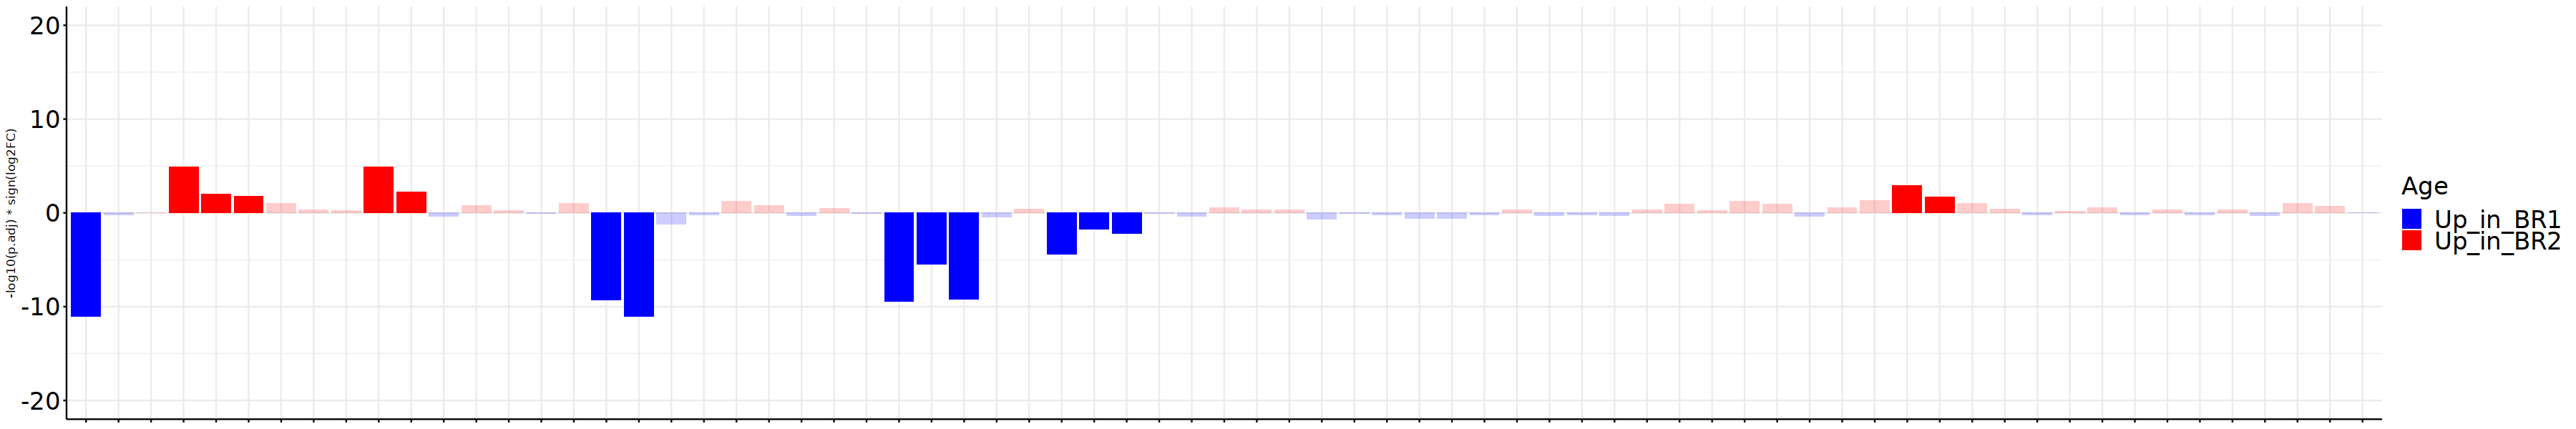

In [196]:
#-log10(p.adj) * sign(log2FC - Age
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_legend <- ifelse(merged_df$product_column >= 0, "Up_in_BR2", "Up_in_BR1")

options(repr.plot.width = 30, repr.plot.height = 5)
p1 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = color_legend)) +
  geom_bar(stat = "identity", , alpha = ifelse(merged_df$p.adj > 0.05, 0.2, 1)) +
  labs(
      #title = "Bar Plot of -log10(p.adj) * sign(log2FC) - Age comparison",
       x = "AIFI_L3",
       y = "-log10(p.adj) * sign(log2FC)") +
  scale_fill_manual(values = c("Up_in_BR1" = "blue", "Up_in_BR2" = "red"),
                    breaks = c("Up_in_BR1", "Up_in_BR2"),
                    labels = c("Up_in_BR1", "Up_in_BR2")) +
  theme_minimal() +
  #coord_flip()+
   theme(strip.text = element_text(size = 15, color= "black"),
                axis.text.x = element_text(color = "black",
                                           size = 20,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 20),
                axis.title.x = element_text(size = 20),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 10),
                legend.title = element_text(size = 20),
                legend.text = element_text(size = 20),
                axis.line = element_line(color = "black", size = 0.5),
                axis.ticks = element_line(color = "black"),
                axis.text = element_text(size = 12))


# Add p-values to the plot using geom_text

p1 <- p1 + 
#geom_text(aes(label = p.adj.signif), vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5), size = 4)+
    coord_cartesian(ylim = c(-20, 20)) + labs(fill= "Age") + theme(axis.title.x = element_blank(), axis.text.x = element_blank())
#+ theme(legend.position = "none")

p1

$fill
[1] "Age"

attr(,"class")
[1] "labels"

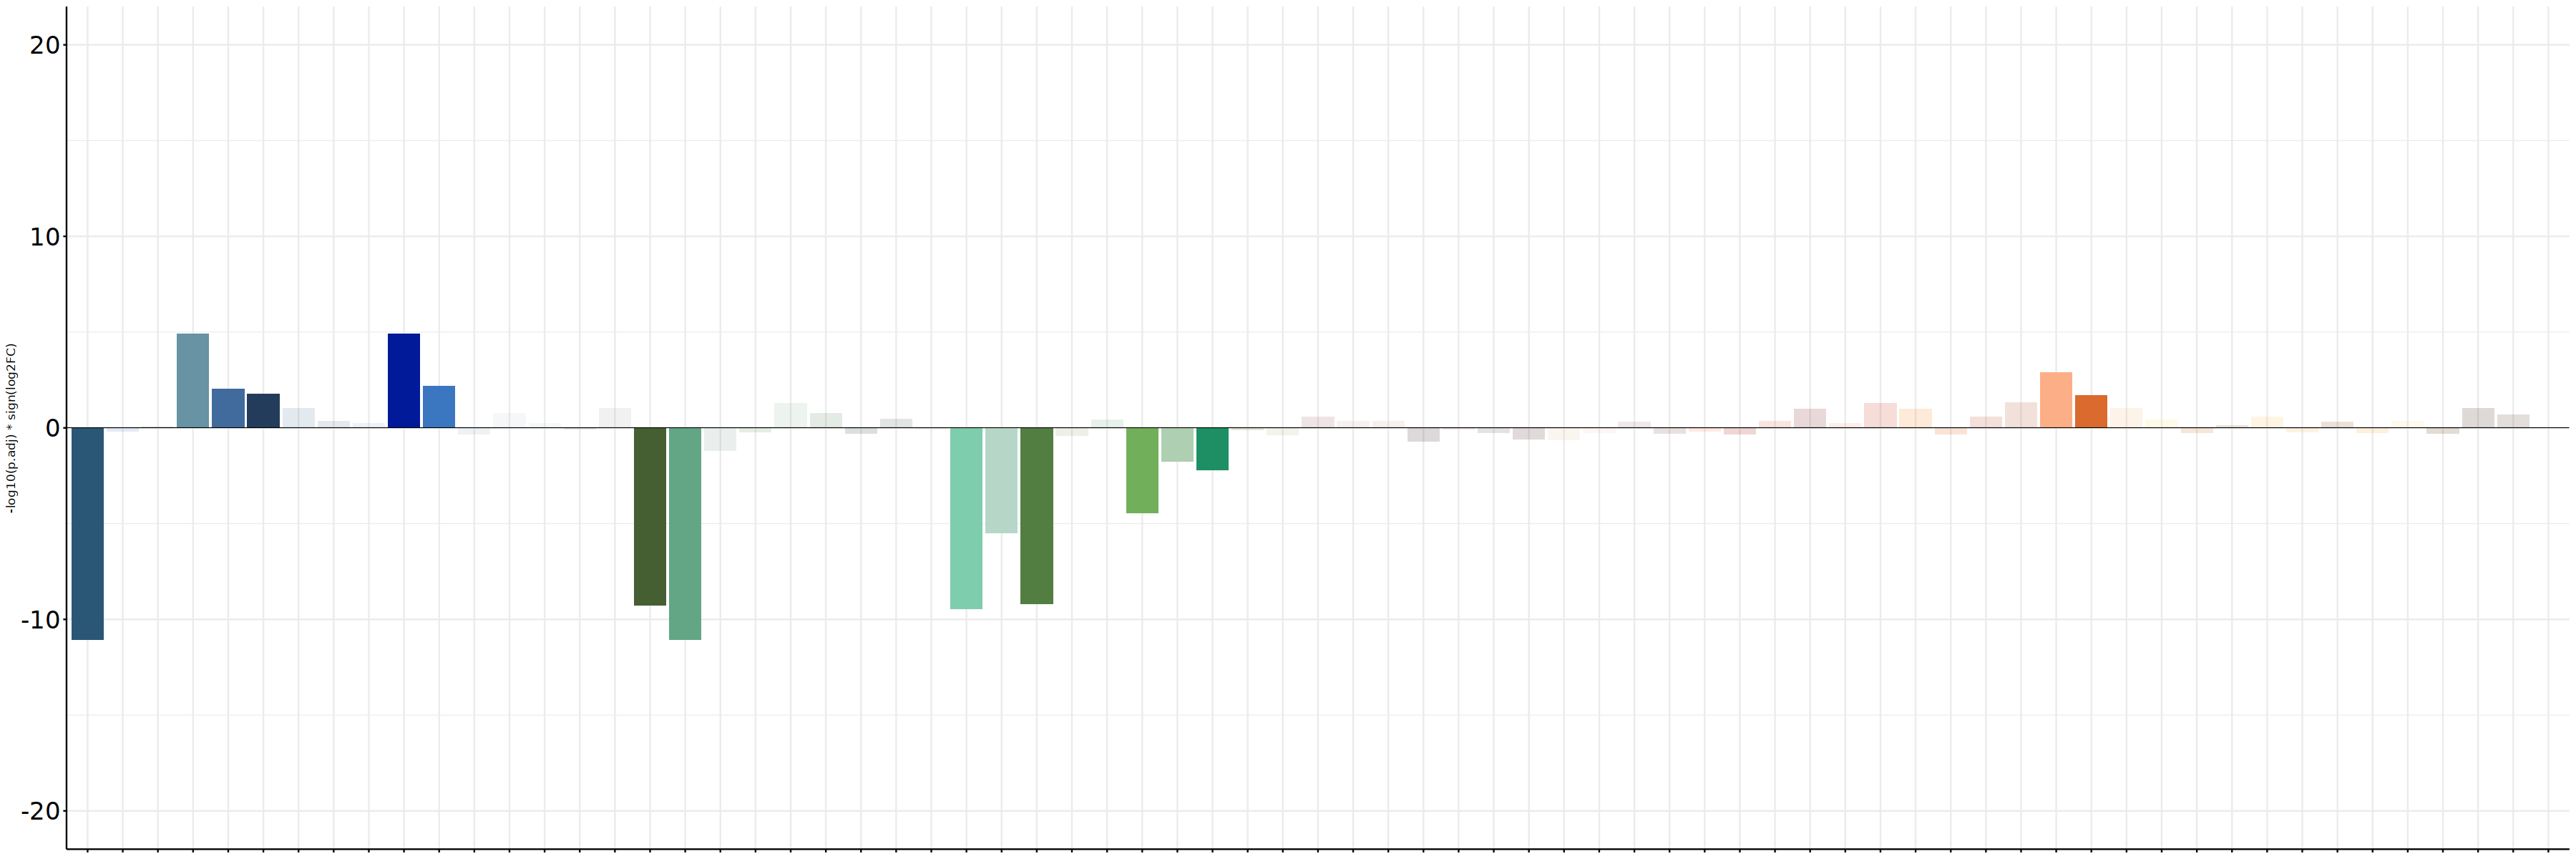

In [413]:
library(ggplot2)

options(repr.plot.width = 30, repr.plot.height = 10)

p1 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = AIFI_L3_color)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.17, 1)) +
  labs(
    x = "AIFI_L3",
    y = "-log10(p.adj) * sign(log2FC)"
  ) +
  scale_fill_identity() +  # To use custom colors from the 'color_legend' column
  theme_minimal() +
  theme(
    strip.text = element_text(size = 15, color= "black"),
    axis.text.x = element_text(color = "black", size = 20, angle = 90, hjust = 1, vjust = 0.5),
    axis.text.y = element_text(color = "black", size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 10),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.line = element_line(color = "black", size = 0.5),
    axis.ticks = element_line(color = "black"),
    axis.text = element_text(size = 12)
  )

p1 <- p1 + 
  coord_cartesian(ylim = c(-20, 20)) + geom_hline(yintercept = 0, color = "black", size = 0.25)+ theme(axis.title.x = element_blank(), axis.text.x = element_blank())
  labs(fill= "Age")

p1



In [365]:
color_legend

[1] #60545A #781B15 #8A4E1C #3D1F15 #F4BA81 #FEDC7A #A3787B #F4CEC3 #6F723F
[10] #FF7F55 #1E8F64 #7ECDAD #EBC3A7 #F8C755 #FCDB97 #6793A4 #6D9F5E #5B3006
[19] #F6831B #FCAF87 #B16B72 #D5ABAB #597FC6 #63A686 #656E68 #362027 #1F1515
[28] #233C5B #406B9C #AECFB1 #314937 #E16040 #95BDA1 #A31001 #A3B7C2 #72AF5A
[37] #BE6E23 #BE4C26 #F4AD3A #B75228 #DE5A07 #DB6A2E #EEA172 #8C6527 #BBB788
[46] #5480A3 #94C0AD #D9A996 #072E77 #869A94 #3B76C1 #C7E0C6 #A39E78 #59895F
[55] #628088 #7CB38E #4E695B #001A9A #C3D1DA #8EB5D7 #537E41 #FBB64E #784D47
[64] #5B3930 #CC3B18 #AEAEB0 #2B5777 #465F32 #B6D7C8 #9C6469 #4E2927
71 Levels: #2B5777 #597FC6 #072E77 #6793A4 #406B9C #233C5B #5480A3 ... #1F1515

## CMV frequency

In [414]:
#continuous code
#
result_cmv <- l3_filt %>%
  dplyr::group_by(AIFI_L3, subject.cmv) %>%
  dplyr::summarise(median_percentage = median(percentage)) 


result_cmv <- result_cmv %>% spread(subject.cmv, median_percentage)


result_cmv <- result_cmv %>%  
        mutate(Median_Diff = (Positive - Negative)) %>%
        mutate(log2FC = log2(Positive/Negative))


stat_test_cmv<- l3_filt %>%
  select(percentage,AIFI_L3_clr, AIFI_L3, subject.cmv) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(AIFI_L3_clr ~ subject.cmv) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()



merged_df <- left_join(result_cmv, stat_test_cmv, by = "AIFI_L3")

# Joining AIFI_L3_color from label_data to merged_df
merged_df <- left_join(merged_df, label_data %>% select(AIFI_L3, AIFI_L3_color), by = "AIFI_L3")

merged_df <- merged_df %>% mutate(minus_log10_p_adj = -log10(p.adj),
                                  sign_log2FC = sign(log2FC),
                                 product_column = (minus_log10_p_adj * sign_log2FC))

merged_df$AIFI_L3 <- factor(merged_df$AIFI_L3, levels = desired_labels)
merged_df$AIFI_L3_color <- factor(merged_df$AIFI_L3_color, levels = desired_color)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


In [415]:
write.csv(merged_df, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_CMV_comparisons.csv")

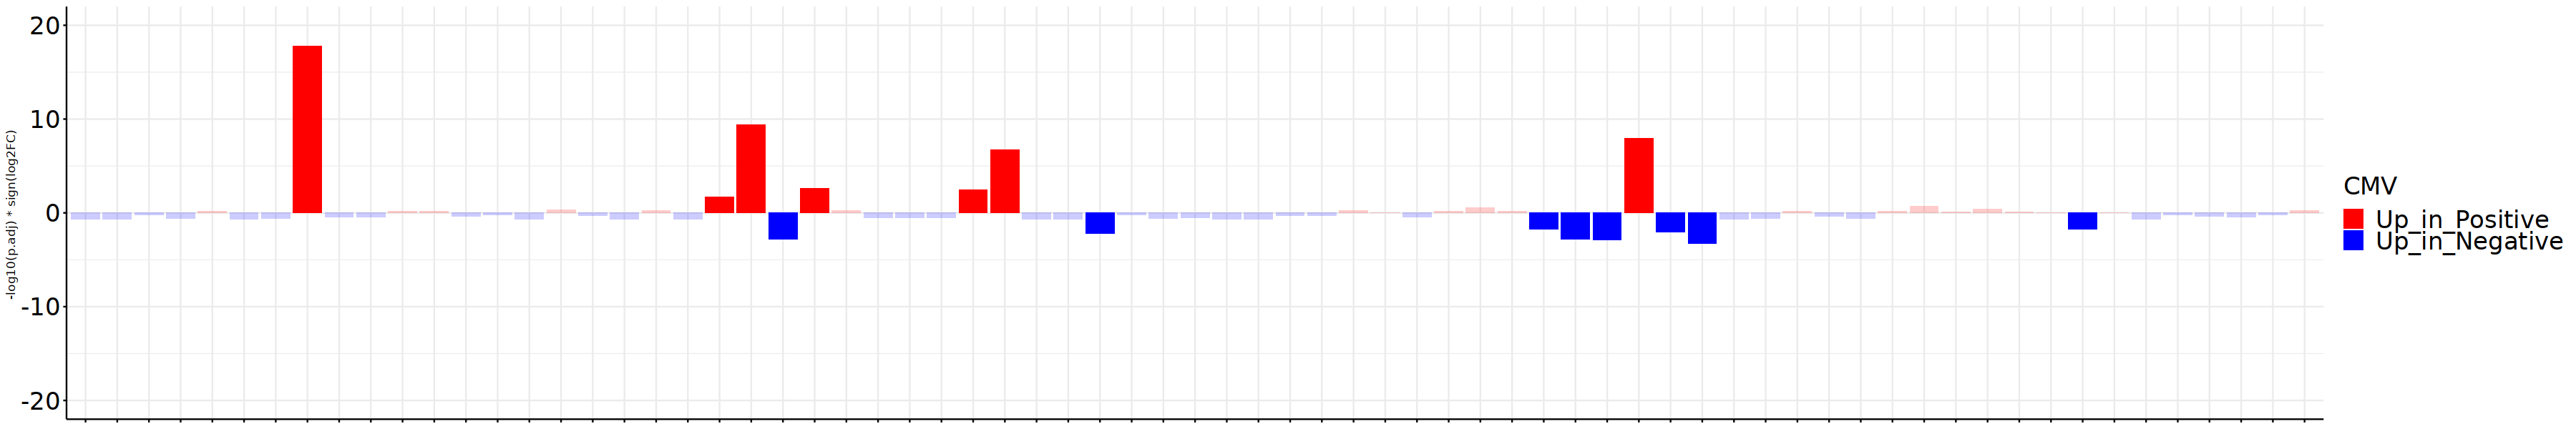

In [201]:
#log2FC(Median_Diff) - CMV
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_legend <- ifelse(merged_df$product_column >= 0, "Up_in_Positive", "Up_in_Negative")

options(repr.plot.width = 30, repr.plot.height = 5)
p2 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = color_legend)) +
  geom_bar(stat = "identity", , alpha = ifelse(merged_df$p.adj > 0.05, 0.2, 1)) +
  labs(
      #title = "Bar Plot of -log10(p.adj) * sign(log2FC)  - CMV comparison",
       x = "AIFI_L3",
       y = "-log10(p.adj) * sign(log2FC) ") +
  scale_fill_manual(values = c("Up_in_Positive" = "red", "Up_in_Negative" = "blue"),
                    breaks = c("Up_in_Positive", "Up_in_Negative"),
                    labels = c("Up_in_Positive", "Up_in_Negative")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15, color= "black"),
                axis.text.x = element_text(color = "black",
                                           size = 20,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 20),
                axis.title.x = element_text(size = 20),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 10),
                legend.title = element_text(size = 20),
                legend.text = element_text(size = 20),
                axis.line = element_line(color = "black", size = 0.5),
                axis.ticks = element_line(color = "black"),
                axis.text = element_text(size = 12),)
               #legend.position = "none")


# Add p-values to the plot using geom_text

p2 <- p2 + 
#geom_text(aes(label = p.adj.signif),  vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5),  size = 4)+
    coord_cartesian(ylim = c(-20, 20)) + labs(fill= "CMV") + theme(axis.title.x = element_blank(), axis.text.x = element_blank())
#+ theme(legend.position = "none")

p2

$fill
[1] "Age"

attr(,"class")
[1] "labels"

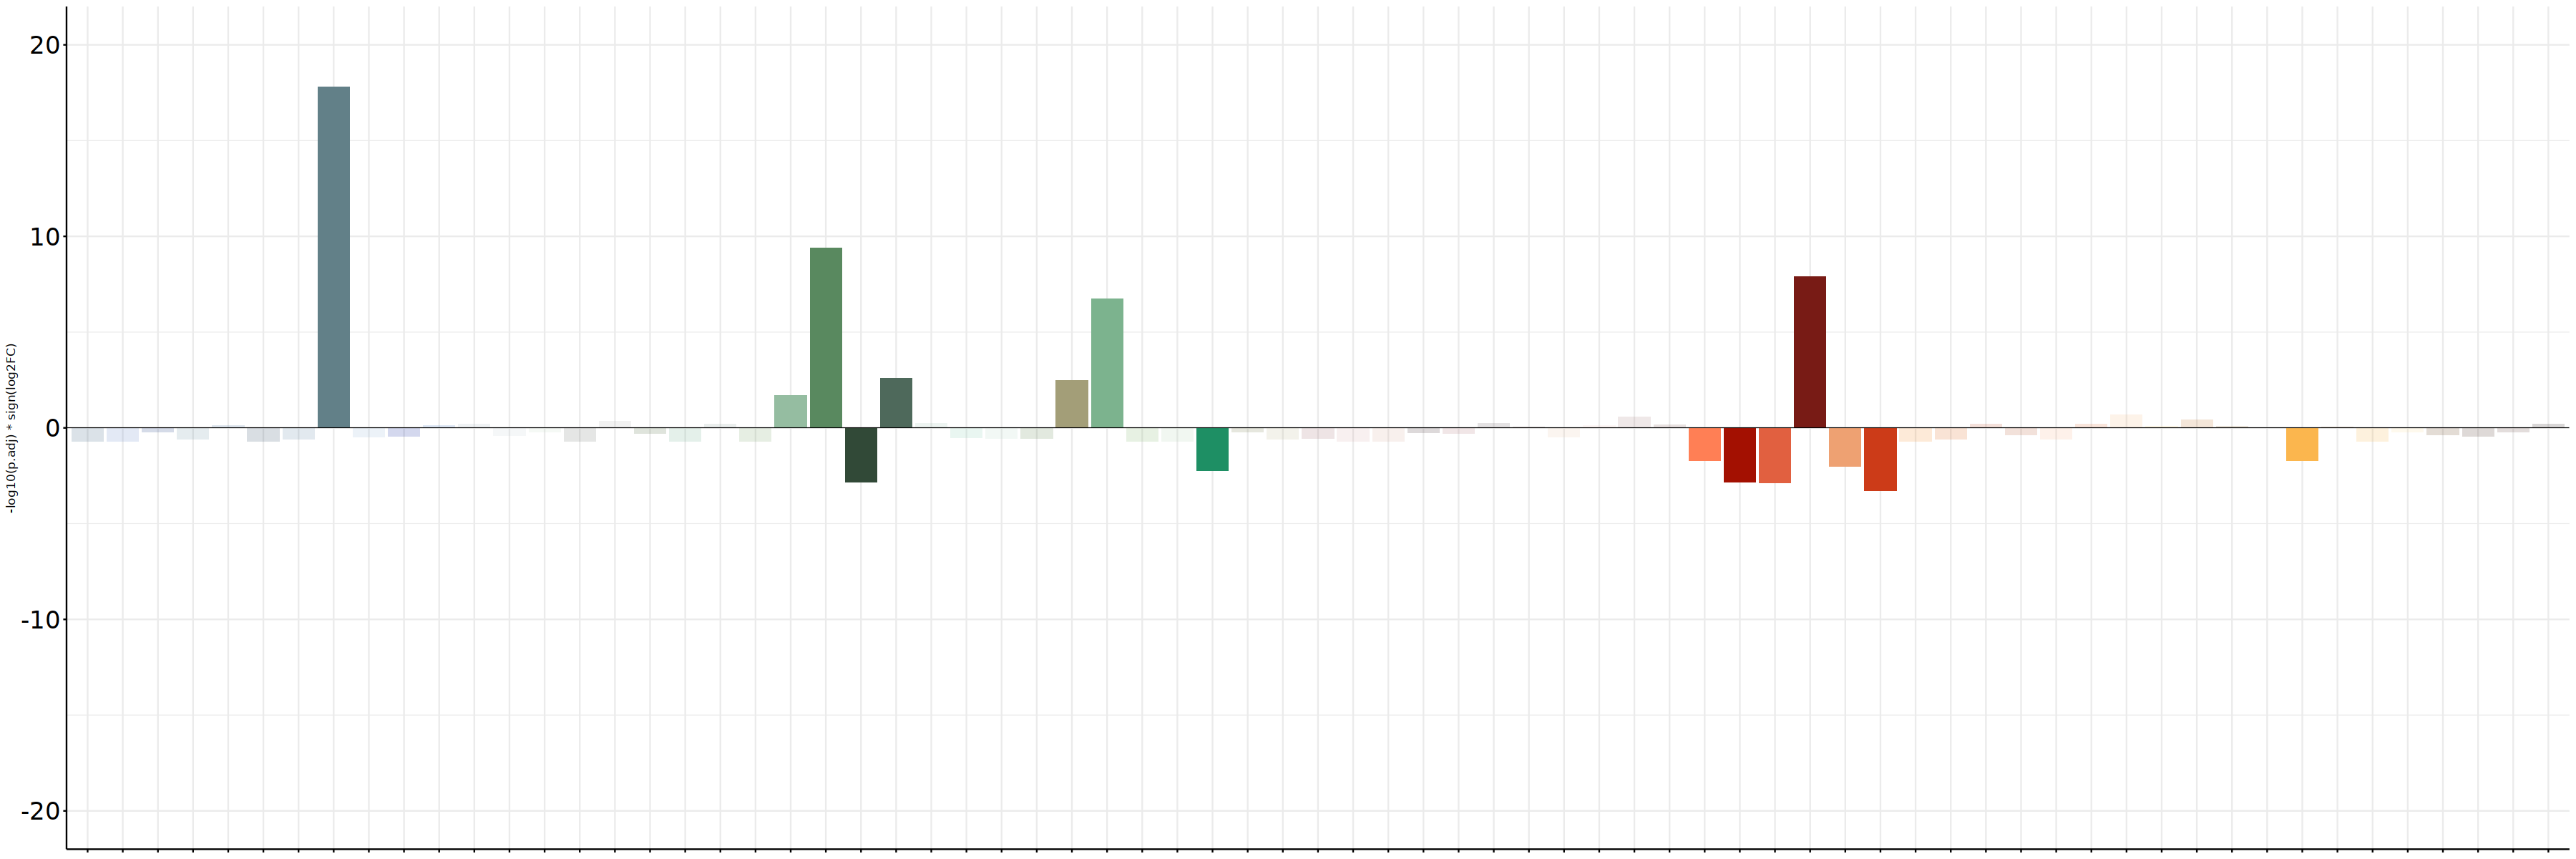

In [416]:
library(ggplot2)

options(repr.plot.width = 30, repr.plot.height = 10)

p2 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = AIFI_L3_color)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.17, 1)) +
  labs(
    x = "AIFI_L3",
    y = "-log10(p.adj) * sign(log2FC)"
  ) +
  scale_fill_identity() +  # To use custom colors from the 'color_legend' column
  theme_minimal() +
  theme(
    strip.text = element_text(size = 15, color= "black"),
    axis.text.x = element_text(color = "black", size = 20, angle = 90, hjust = 1, vjust = 0.5),
    axis.text.y = element_text(color = "black", size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 10),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.line = element_line(color = "black", size = 0.5),
    axis.ticks = element_line(color = "black"),
    axis.text = element_text(size = 12)
  )

p2 <- p2 + 
  coord_cartesian(ylim = c(-20, 20)) + geom_hline(yintercept = 0, color = "black", size = 0.25)+ theme(axis.title.x = element_blank(), axis.text.x = element_blank())
  labs(fill= "Age")

p2



## Sex Frequency

In [448]:
#continuous code
#
result_sex <- l3_filt %>%
  dplyr::group_by(AIFI_L3, subject.biologicalSex) %>%
  dplyr::summarise(median_percentage = median(percentage)) 


result_sex <- result_sex %>% spread(subject.biologicalSex, median_percentage)


result_sex <- result_sex %>%  
        mutate(Median_Diff = (Female - Male)) %>%
        mutate(log2FC = log2(Female/Male))


stat_test_sex<- l3_filt %>%
  select(percentage,AIFI_L3_clr, AIFI_L3, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>% 
  wilcox_test(AIFI_L3_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()

significant_cell_types <- stat_test_sex %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p, p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types)



merged_df <- left_join(result_sex, stat_test_sex, by = "AIFI_L3")

# Joining AIFI_L3_color from label_data to merged_df
merged_df <- left_join(merged_df, label_data %>% select(AIFI_L3, AIFI_L3_color), by = "AIFI_L3")

merged_df <- merged_df %>% mutate(minus_log10_p_adj = -log10(p.adj),
                                  sign_log2FC = sign(log2FC),
                                 product_column = (minus_log10_p_adj * sign_log2FC))

merged_df$AIFI_L3 <- factor(merged_df$AIFI_L3, levels = desired_labels)
merged_df$AIFI_L3_color <- factor(merged_df$AIFI_L3_color, levels = desired_color)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


# A tibble: 0 × 5
# ℹ 5 variables: AIFI_L3 <chr>, .y. <chr>, p <dbl>, p.adj <dbl>,
#   p.adj.signif <chr>


In [449]:
write.csv(merged_df, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Sex_comparisons.csv")

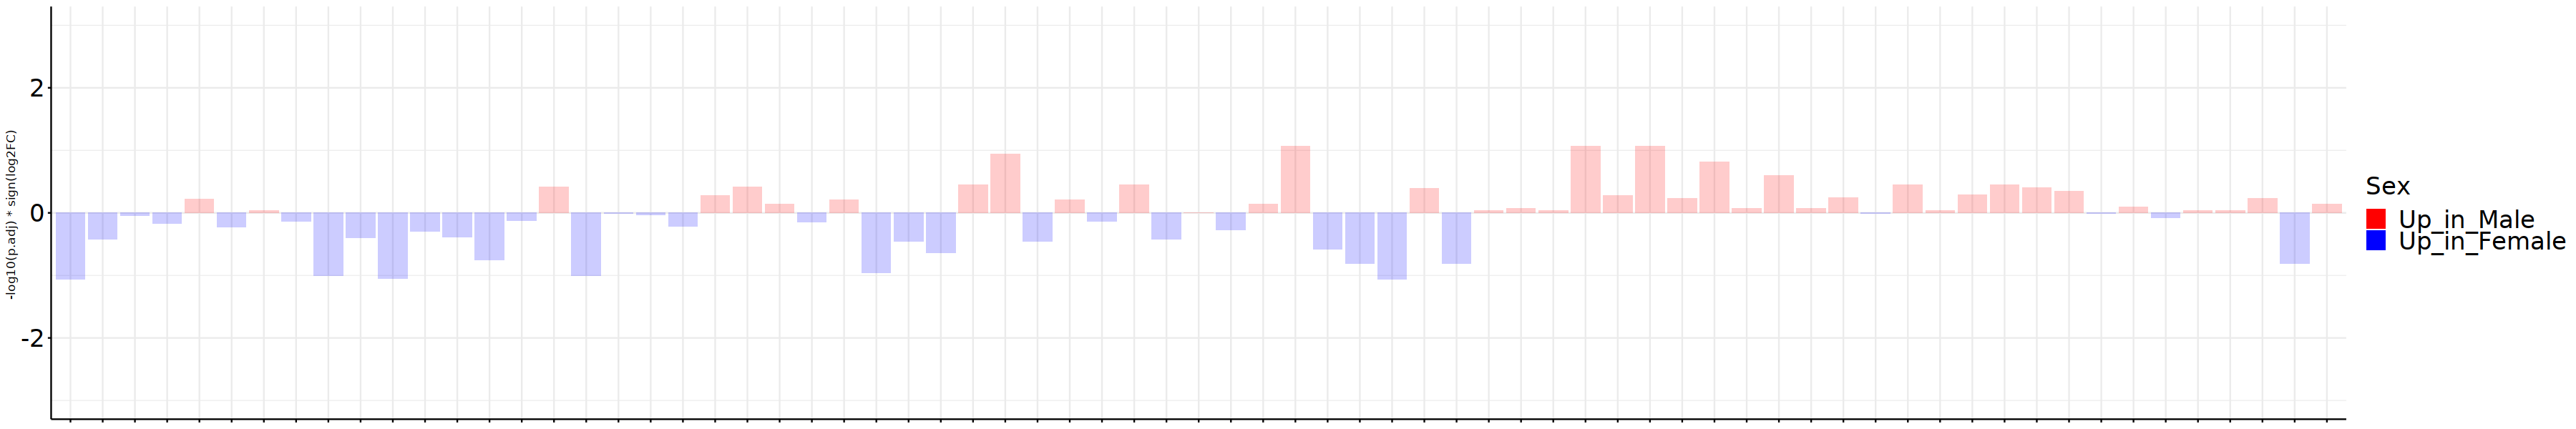

In [302]:
#-log10(p.adj) * sign(log2FC)  - Sex
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_legend <- ifelse(merged_df$product_column >= 0, "Up_in_Female", "Up_in_Male")

options(repr.plot.width = 30, repr.plot.height = 5)
p3 <- ggplot(merged_df, aes(x = AIFI_L3, y = -product_column, fill = color_legend)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.2, 1)) +
  labs(
      #title = "Bar Plot of log2FC(Median_Diff) - Sex comparison",
       x = "AIFI_L3",
       y = "-log10(p.adj) * sign(log2FC) ") +
  scale_fill_manual(values = c("Up_in_Male" = "red", "Up_in_Female" = "blue"),
                    breaks = c("Up_in_Male", "Up_in_Female"),
                    labels = c("Up_in_Male", "Up_in_Female")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15, color= "black"),
                axis.text.x = element_text(color = "black",
                                           size = 20,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 20),
                axis.title.x = element_text(size = 20),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 10),
                legend.title = element_text(size = 20),
                legend.text = element_text(size = 20),
                axis.line = element_line(color = "black", size = 0.5),
                axis.ticks = element_line(color = "black"),
                axis.text = element_text(size = 12),)
                #legend.position= "none")


# Add p-values to the plot using geom_text

p3 <- p3 + 
#geom_text(aes(label = p.adj.signif), vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5), size = 4)+
    coord_cartesian(ylim = c(-3, 3)) + labs(fill= "Sex") + theme(axis.title.x = element_blank(), axis.text.x = element_blank())
#+ theme(legend.position = "none")
 
p3

$fill
[1] "Age"

attr(,"class")
[1] "labels"

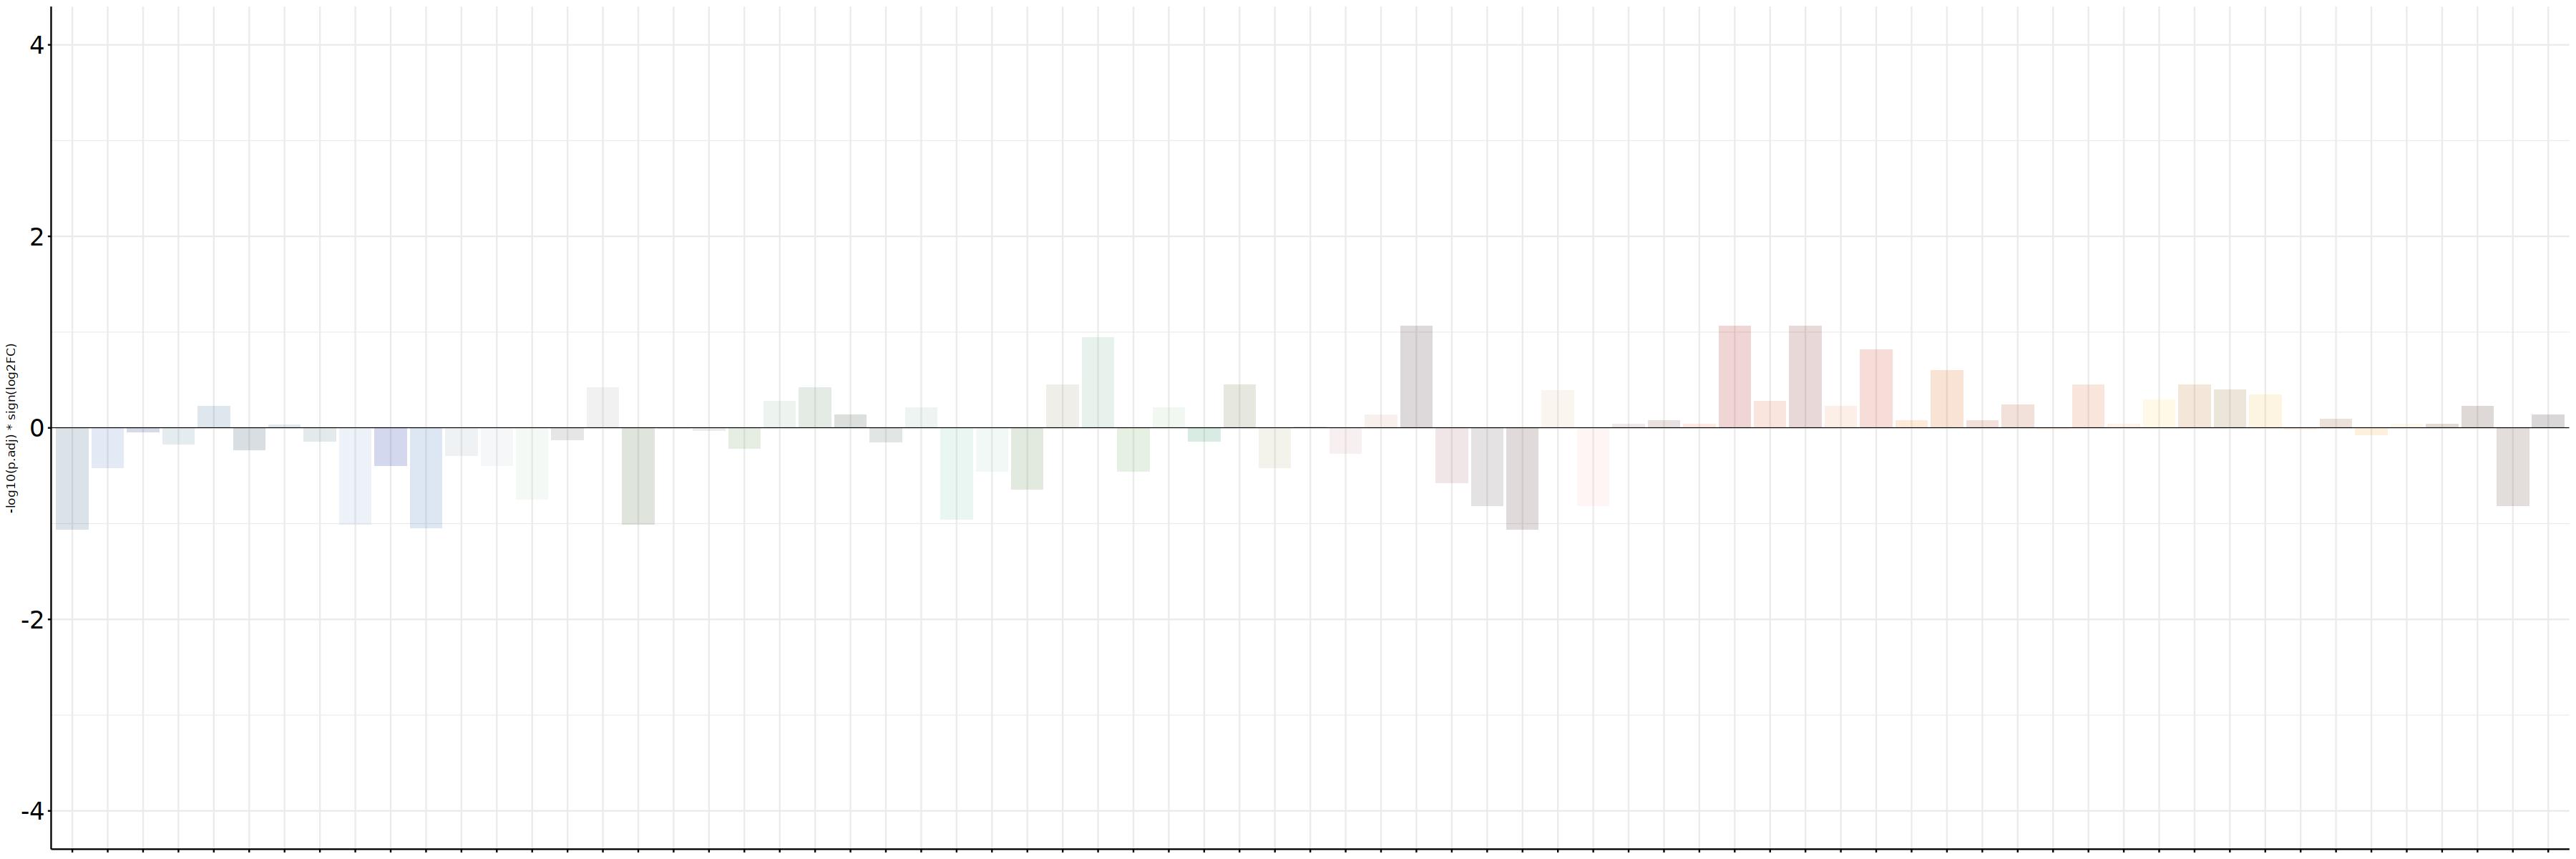

In [453]:
library(ggplot2)

options(repr.plot.width = 30, repr.plot.height = 10)

p3 <- ggplot(merged_df, aes(x = AIFI_L3, y = -product_column, fill = AIFI_L3_color)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.17, 1)) +
  labs(
    x = "AIFI_L3",
    y = "-log10(p.adj) * sign(log2FC)"
  ) +
  scale_fill_identity() +  # To use custom colors from the 'color_legend' column
  theme_minimal() +
  theme(
    strip.text = element_text(size = 15, color= "black"),
    axis.text.x = element_text(color = "black", size = 20, angle = 90, hjust = 1, vjust = 0.5),
    axis.text.y = element_text(color = "black", size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 10),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.line = element_line(color = "black", size = 0.5),
    axis.ticks = element_line(color = "black"),
    axis.text = element_text(size = 12)
  )

p3 <- p3 + 
  coord_cartesian(ylim = c(-4, 4)) + geom_hline(yintercept = 0, color = "black", size = 0.25)+ theme(axis.title.x = element_blank(), axis.text.x = element_blank())
  labs(fill= "Age")

p3



## Null Vax frequency

In [437]:
unique(l3$sample.visitName)

[1] "Flu Year 1 Day 0"        "Flu Year 1 Day 7"       
 [3] "Flu Year 1 Day 90"       "Immune Variation Day 0" 
 [5] "Immune Variation Day 7"  "Immune Variation Day 90"
 [7] "Flu Year 2 Stand-Alone"  "Flu Year 1 Stand-Alone" 
 [9] "Flu Year 2 Day 0"        "Flu Year 2 Day 7"       
[11] "Flu Year 2 Day 90"       "Flu Year 3 Stand-Alone"

In [438]:
l3_filt_null <- l3 %>% filter(sample.visitName %in% c('Immune Variation Day 0', 'Immune Variation Day 7'))
unique(l3_filt_null$sample.visitName)

[1] "Immune Variation Day 0" "Immune Variation Day 7"

In [439]:
null_paired <- l3_filt_null %>%
  group_by(AIFI_L3,subject.subjectGuid) %>%
  filter(all(c("Immune Variation Day 0", "Immune Variation Day 7") %in% sample.visitName))
#head(filtered_data)
dim(l3_filt_null)

[1] 12097    25

In [440]:
null_paired <- null_paired %>% dplyr::mutate(percentage = (AIFI_L3_frac_total * 100))

In [441]:
#continuous code
#
result_null<- null_paired %>%
  dplyr::group_by(AIFI_L3, sample.visitName) %>%
  dplyr::summarise(median_percentage = median(percentage)) 


result_null <- result_null %>% spread(sample.visitName, median_percentage)


result_null <- result_null %>%  
        mutate(Median_Diff = (`Immune Variation Day 0` - `Immune Variation Day 7`)) %>%
        mutate(log2FC = log2(`Immune Variation Day 0` / `Immune Variation Day 7`))


stat_test_null<- null_paired %>%
  select(percentage,AIFI_L3_clr, AIFI_L3, sample.visitName) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid)%>%
  wilcox_test(AIFI_L3_clr ~ sample.visitName, paired=TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()



merged_df <- left_join(result_null, stat_test_null, by = "AIFI_L3")

# Joining AIFI_L3_color from label_data to merged_df
merged_df <- left_join(merged_df, label_data %>% select(AIFI_L3, AIFI_L3_color), by = "AIFI_L3")

merged_df <- merged_df %>% mutate(minus_log10_p_adj = -log10(p.adj),
                                  sign_log2FC = sign(log2FC),
                                 product_column = (minus_log10_p_adj * sign_log2FC))

merged_df$AIFI_L3 <- factor(merged_df$AIFI_L3, levels = desired_labels)
merged_df$AIFI_L3_color <- factor(merged_df$AIFI_L3_color, levels = desired_color)


`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.
Adding missing grouping variables: `subject.subjectGuid`


In [442]:
write.csv(merged_df, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Null_comparisons.csv")

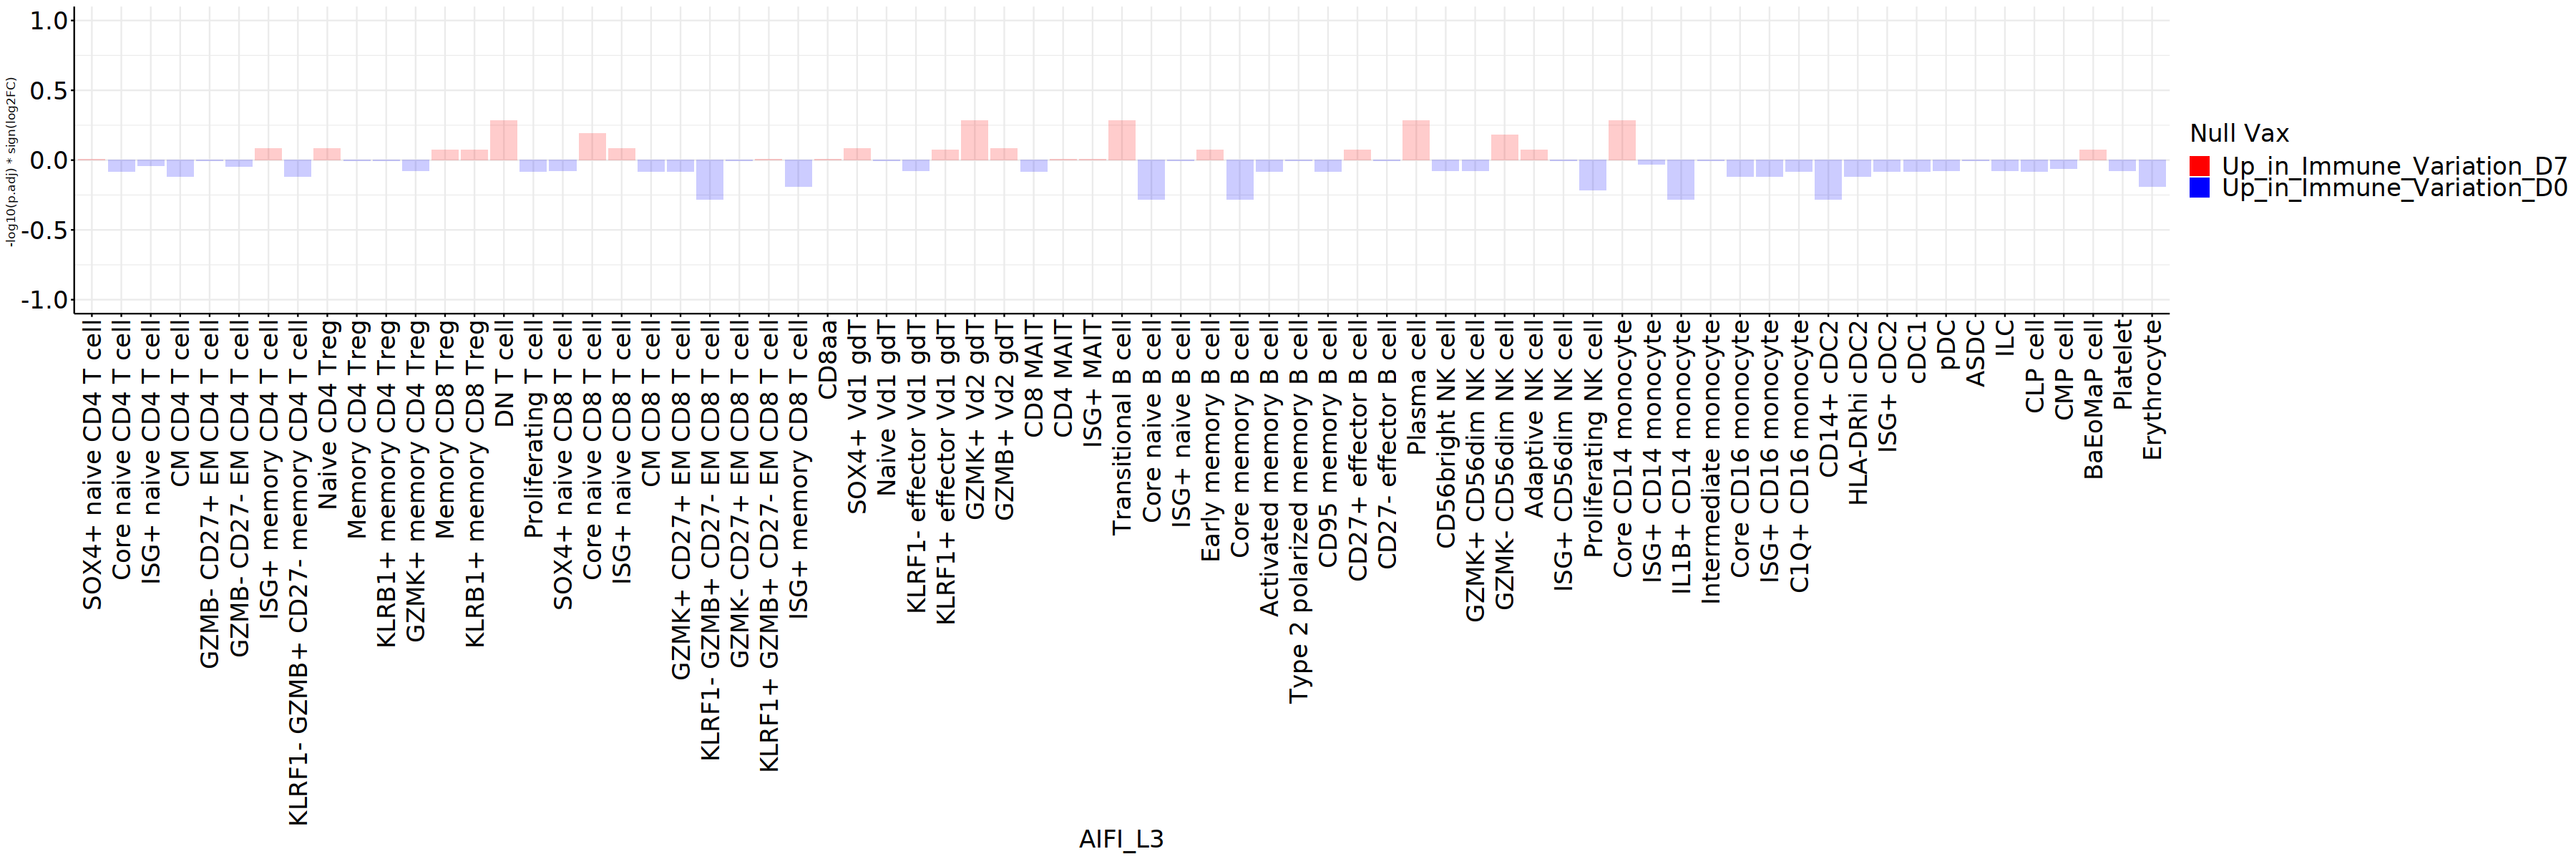

In [309]:
#-log10(p.adj) * sign(log2FC)  - null
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_legend <- ifelse(merged_df$product_column >= 0, "Up_in_Immune_Variation_D7", "Up_in_Immune_Variation_D0")

options(repr.plot.width = 30, repr.plot.height = 10)
p4 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = color_legend)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.2, 1)) +
  labs(
      #title = "Bar Plot of -log10(p.adj) * sign(log2FC) - Null Vax comparison",
       x = "AIFI_L3",
       y = "-log10(p.adj) * sign(log2FC) ") +
  scale_fill_manual(values = c("Up_in_Immune_Variation_D7" = "red", "Up_in_Immune_Variation_D0" = "blue"),
                    breaks = c("Up_in_Immune_Variation_D7", "Up_in_Immune_Variation_D0"),
                    labels = c("Up_in_Immune_Variation_D7", "Up_in_Immune_Variation_D0")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15, color= "black"),
                axis.text.x = element_text(color = "black",
                                           size = 20,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 20),
                axis.title.x = element_text(size = 20),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 10),
                legend.title = element_text(size = 20),
                legend.text = element_text(size = 20),
                axis.line = element_line(color = "black", size = 0.5),
                axis.ticks = element_line(color = "black"),
                axis.text = element_text(size = 12),)
                #legend.position= "none")


# Add p-values to the plot using geom_text

p4 <- p4 + #geom_text(aes(label = p.adj.signif), vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5), size = 4)+
    coord_cartesian(ylim = c(-1, 1)) + labs(fill= "Null Vax")#+ theme(axis.title.x = element_blank(), axis.text.x = element_blank())
#+ theme(legend.position = "none")

p4

$fill
[1] "Age"

attr(,"class")
[1] "labels"

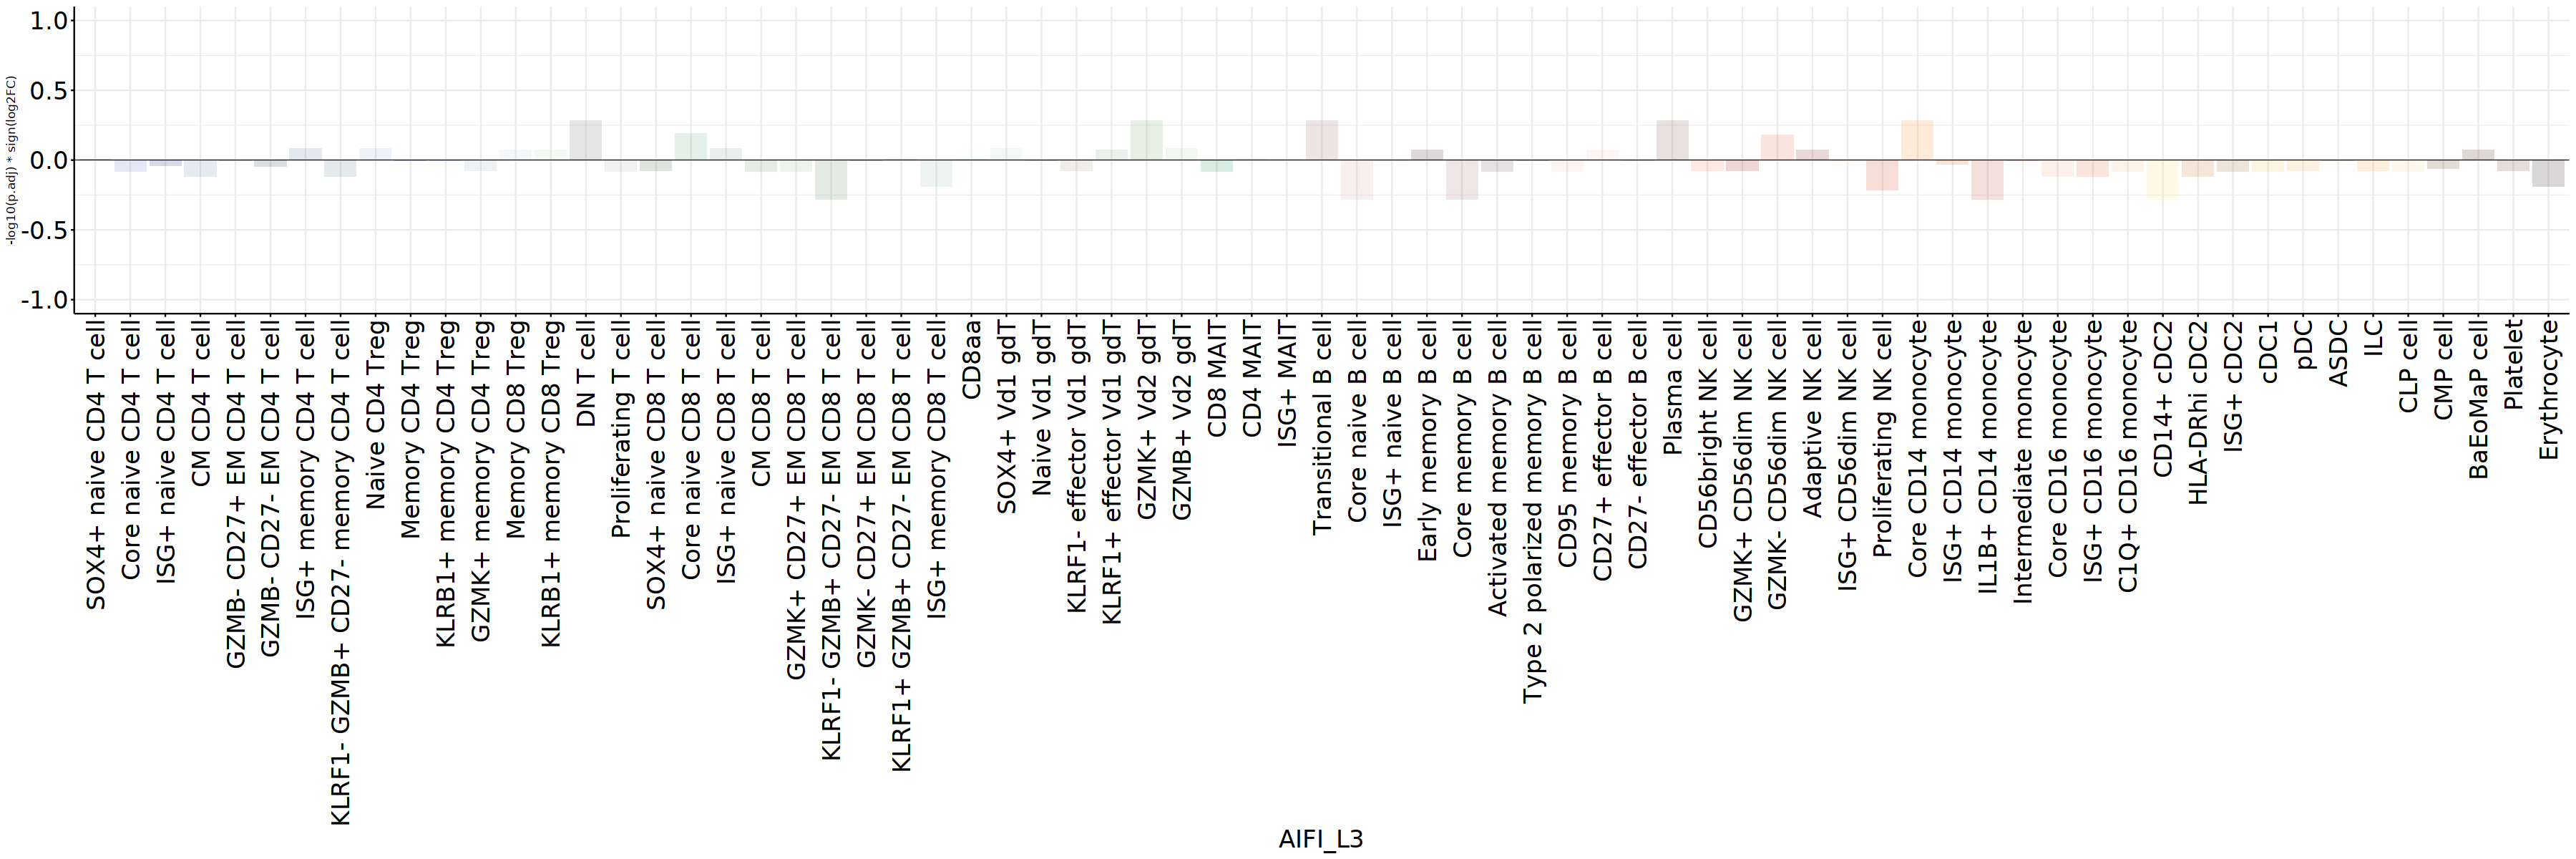

In [443]:
library(ggplot2)

options(repr.plot.width = 30, repr.plot.height = 10)

p4 <- ggplot(merged_df, aes(x = AIFI_L3, y = product_column, fill = AIFI_L3_color)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.17, 1)) +
  labs(
    x = "AIFI_L3",
    y = "-log10(p.adj) * sign(log2FC)"
  ) +
  scale_fill_identity() +  # To use custom colors from the 'color_legend' column
  theme_minimal() +
  theme(
    strip.text = element_text(size = 15, color= "black"),
    axis.text.x = element_text(color = "black", size = 20, angle = 90, hjust = 1, vjust = 0.5),
    axis.text.y = element_text(color = "black", size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 10),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.line = element_line(color = "black", size = 0.5),
    axis.ticks = element_line(color = "black"),
    axis.text = element_text(size = 12)
  )

p4 <- p4 + 
  coord_cartesian(ylim = c(-1, 1)) + geom_hline(yintercept = 0, color = "black", size = 0.25)
  labs(fill= "Age")

p4



## Flu frequency

In [427]:
l3_filt_flu <- l3 %>% filter(sample.visitName == "Flu Year 1 Day 0" | sample.visitName == "Flu Year 1 Day 7")
unique(l3_filt_flu$sample.visitName)
dim(l3_filt_flu)

[1] "Flu Year 1 Day 0" "Flu Year 1 Day 7"

[1] 12554    25

In [428]:
#finding samples that are paired

flu_paired <- l3_filt_flu %>%
  group_by(AIFI_L3,subject.subjectGuid) %>%
  filter(all(c("Flu Year 1 Day 0", "Flu Year 1 Day 7") %in% sample.visitName))
#head(filtered_data)
dim(flu_paired)

[1] 12282    25

In [429]:
flu_paired <- flu_paired %>% dplyr::mutate(percentage = (AIFI_L3_frac_total * 100))

In [430]:
#continuous code
#
result_flu <- flu_paired %>%
  dplyr::group_by(AIFI_L3, sample.visitName) %>%
  dplyr::summarise(mean_percentage = mean(percentage),
                    median_percentage = median(percentage))

result_flu<- result_flu[, c("AIFI_L3", "sample.visitName", "median_percentage")]


result_flu <- result_flu %>% spread(sample.visitName, median_percentage)

result_flu <- result_flu %>%  
          mutate(Median_Diff = (`Flu Year 1 Day 0` - `Flu Year 1 Day 7`)) %>%
          mutate(log2FC = log2(`Flu Year 1 Day 0` / `Flu Year 1 Day 7`))
#head(result_df_median)


stat_test_flu<- flu_paired %>%
  select(percentage,AIFI_L3_clr, AIFI_L3, sample.visitName) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid) %>%
  wilcox_test(AIFI_L3_clr ~ sample.visitName, paired= TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()

significant_cell_types <- stat_test_flu %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p, p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types)

merged_df <- merge(result_flu, stat_test_flu, by = "AIFI_L3")

# Joining AIFI_L3_color from label_data to merged_df
merged_df <- left_join(merged_df, label_data %>% select(AIFI_L3, AIFI_L3_color), by = "AIFI_L3")

merged_df <- merged_df %>% mutate(minus_log10_p_adj = -log10(p.adj),
                                  sign_log2FC = sign(log2FC),
                                 product_column = (minus_log10_p_adj * sign_log2FC))

merged_df$AIFI_L3 <- factor(merged_df$AIFI_L3, levels = desired_labels)
merged_df$AIFI_L3_color <- factor(merged_df$AIFI_L3_color, levels = desired_color)




`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.
Adding missing grouping variables: `subject.subjectGuid`


# A tibble: 11 × 5
   AIFI_L3                   .y.                   p     p.adj p.adj.signif
   <chr>                     <chr>             <dbl>     <dbl> <chr>       
 1 CD27+ effector B cell     AIFI_L3_clr 0.00000209  0.0000554 ****        
 2 CD27- effector B cell     AIFI_L3_clr 0.00000278  0.0000554 ****        
 3 CD95 memory B cell        AIFI_L3_clr 0.0000183   0.000260  ***         
 4 CM CD4 T cell             AIFI_L3_clr 0.000518    0.00549   **          
 5 Core naive CD4 T cell     AIFI_L3_clr 0.00429     0.0338    *           
 6 GZMB- CD27+ EM CD4 T cell AIFI_L3_clr 0.000541    0.00549   **          
 7 ISG+ CD14 monocyte        AIFI_L3_clr 0.00000312  0.0000554 ****        
 8 ISG+ memory CD8 T cell    AIFI_L3_clr 0.00523     0.0371    *           
 9 ISG+ naive CD4 T cell     AIFI_L3_clr 0.00717     0.0463    *           
10 Intermediate monocyte     AIFI_L3_clr 0.00111     0.00985   **          
11 Plasma cell               AIFI_L3_clr 0.000000506 0.0000359 ****  

In [431]:
write.csv(merged_df, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Flu_comparisons.csv")

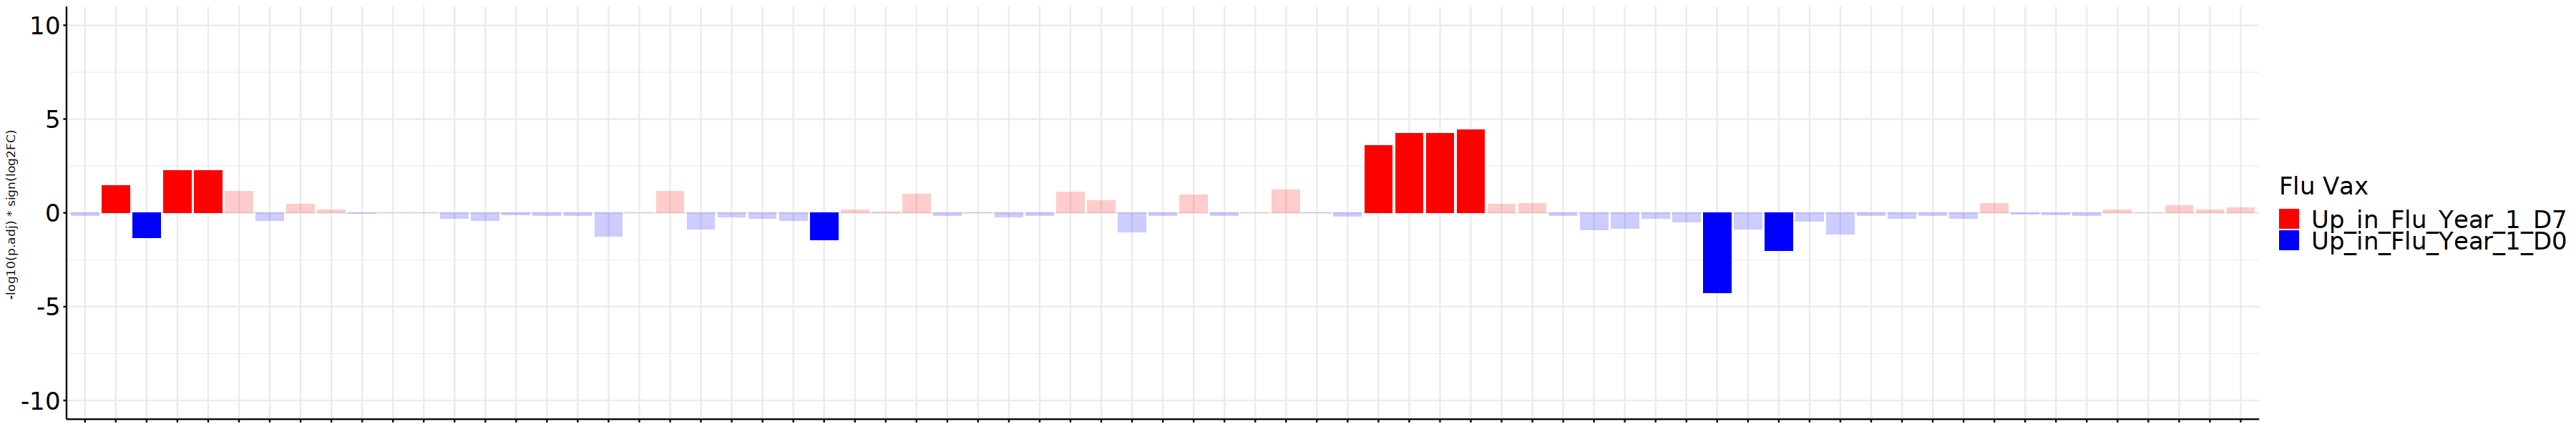

In [432]:
#-log10(p.adj) * sign(log2FC)  - flu
library(ggplot2)

# Create a new column for color based on Mean_Diff
merged_df$color_legend <- ifelse(merged_df$product_column >= 0, "Up_in_Flu_Year_1_D0", "Up_in_Flu_Year_1_D7")

options(repr.plot.width = 30, repr.plot.height =5)
p5 <- ggplot(merged_df, aes(x = AIFI_L3, y = -product_column, fill = color_legend)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.2, 1)) +
  labs(
      #title = "Bar Plot of -log10(p.adj) * sign(log2FC) - Flu comparison",
       x = "AIFI_L3",
       y = "-log10(p.adj) * sign(log2FC) ") +
  scale_fill_manual(values = c( "Up_in_Flu_Year_1_D7" = "red", "Up_in_Flu_Year_1_D0" = "blue"),
                    breaks = c("Up_in_Flu_Year_1_D7", "Up_in_Flu_Year_1_D0"),
                    labels = c("Up_in_Flu_Year_1_D7", "Up_in_Flu_Year_1_D0")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  #coord_flip()+
  theme_minimal() +
  theme(strip.text = element_text(size = 15, color= "black"),
                axis.text.x = element_text(color = "black",
                                           size = 20,
                                           angle = 90,
                                           hjust = 1,
                                           vjust = 0.5),
                axis.text.y = element_text(color = "black", size = 20),
                axis.title.x = element_text(size = 20),  # Adjust the font size of x-axis title
                axis.title.y = element_text(size = 10),
                legend.title = element_text(size = 20),
                legend.text = element_text(size = 20),
                axis.line = element_line(color = "black", size = 0.5),
                axis.ticks = element_line(color = "black"),
                axis.text = element_text(size = 12),)
               #legend.position = "none")


# Add p-values to the plot using geom_text

p5 <- p5  + 
#geom_text(aes(label = p.adj.signif), vjust = ifelse(merged_df$log2FC >= 0, 0, 1.5), size = 4)+
    coord_cartesian(ylim = c(-10, 10)) + labs(fill= "Flu Vax") + theme(axis.title.x = element_blank(), axis.text.x = element_blank())
#+ theme(legend.position = "none")

p5

$fill
[1] "Age"

attr(,"class")
[1] "labels"

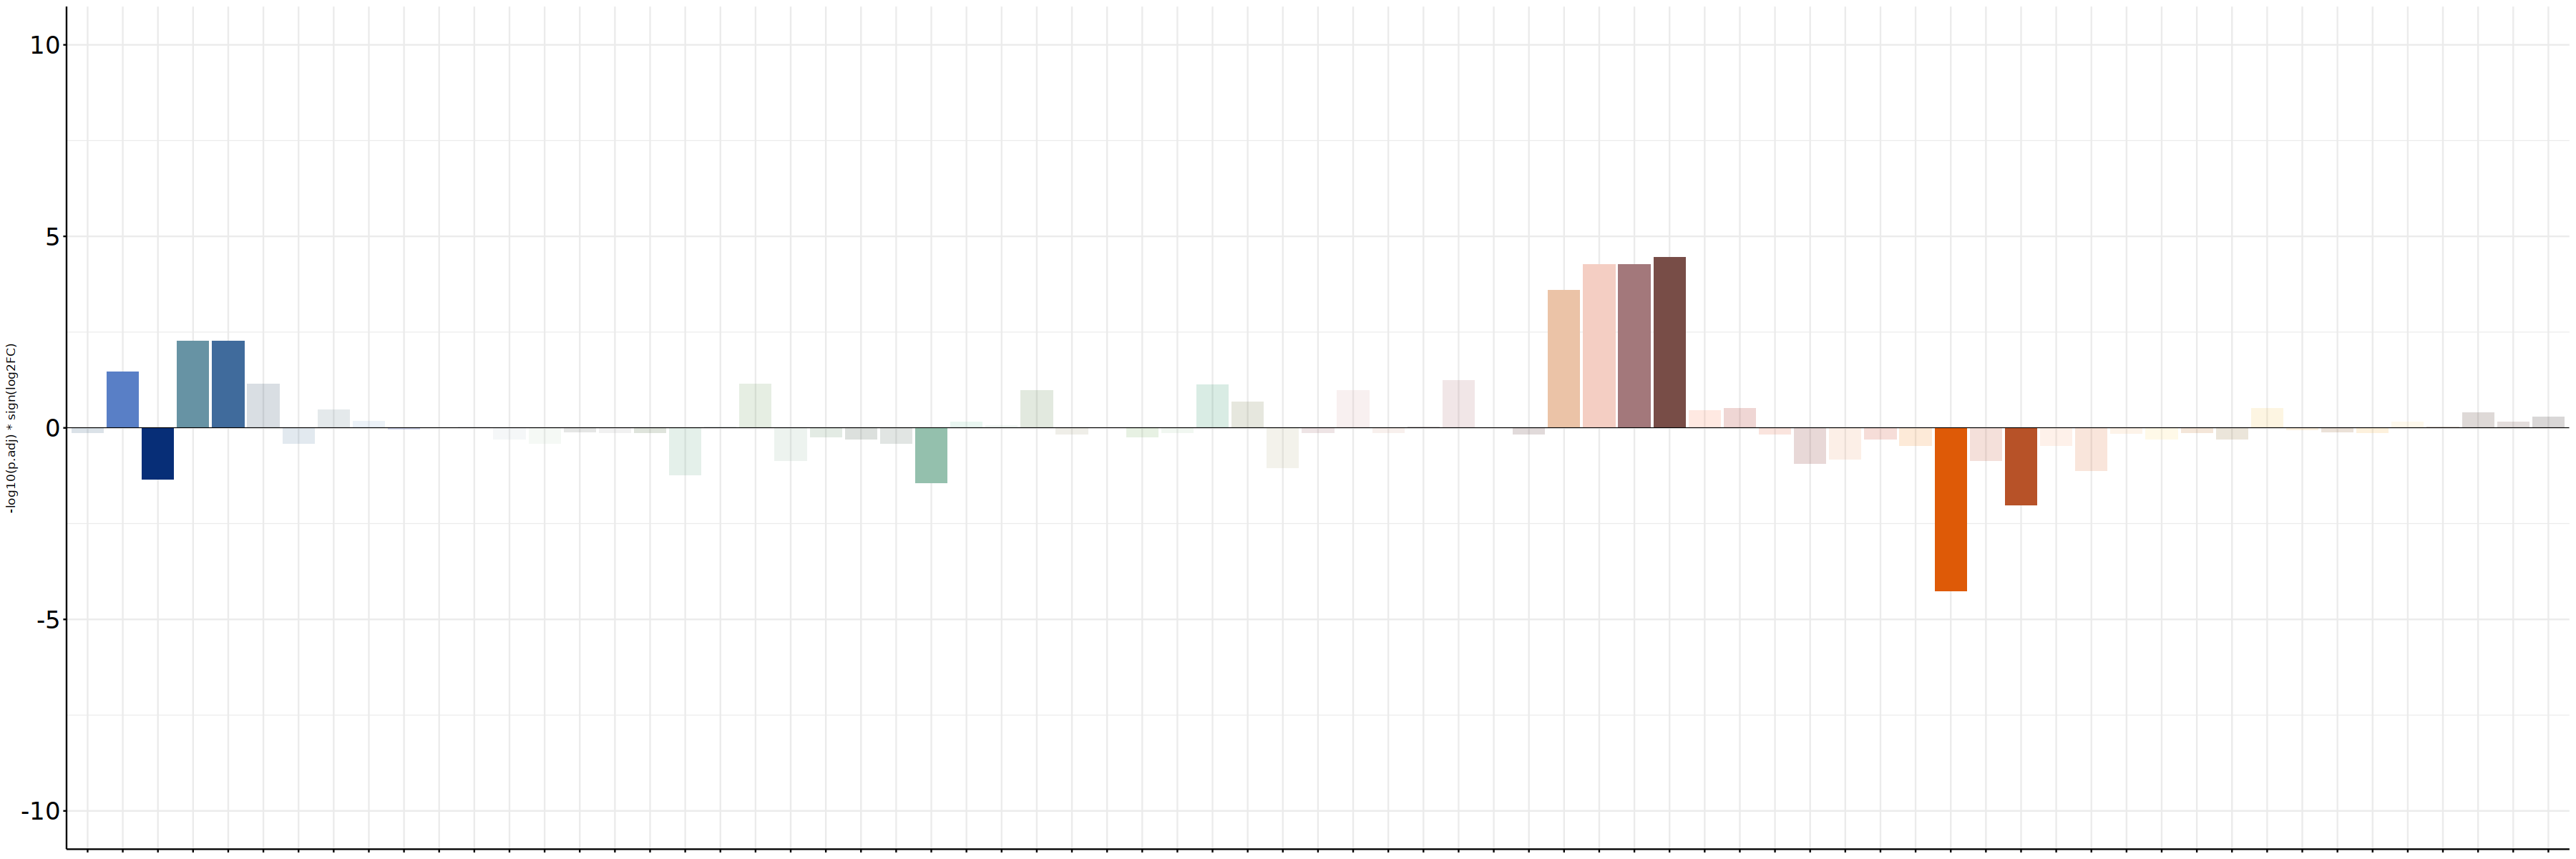

In [433]:
library(ggplot2)

options(repr.plot.width = 30, repr.plot.height = 10)

p5 <- ggplot(merged_df, aes(x = AIFI_L3, y = -product_column, fill = AIFI_L3_color)) +
  geom_bar(stat = "identity", alpha = ifelse(merged_df$p.adj > 0.05, 0.17, 1)) +
  labs(
    x = "AIFI_L3",
    y = "-log10(p.adj) * sign(log2FC)"
  ) +
  scale_fill_identity() +  # To use custom colors from the 'color_legend' column
  theme_minimal() +
  theme(
    strip.text = element_text(size = 15, color= "black"),
    axis.text.x = element_text(color = "black", size = 20, angle = 90, hjust = 1, vjust = 0.5),
    axis.text.y = element_text(color = "black", size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 10),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.line = element_line(color = "black", size = 0.5),
    axis.ticks = element_line(color = "black"),
    axis.text = element_text(size = 12)
  )

p5 <- p5 + 
  coord_cartesian(ylim = c(-10, 10)) + geom_hline(yintercept = 0, color = "black", size = 0.25)+ theme(axis.title.x = element_blank(), axis.text.x = element_blank())
  labs(fill= "Age")

p5



# Stack the plots together

In [434]:
library(ggpubr)
library(gridExtra)

In [454]:
options(repr.plot.width = 30, repr.plot.height = 20)
outfile <- paste("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Plots/Global_frequencies_Fig2.pdf", sep="")
stacked_plots <- ggarrange(p1, p3,p2, p5, p4, nrow = 5, align = "v", heights= c(1,1,1,1,3.25), widths = c(4, 4, 4, 4, 20) )
#grid.arrange(nDEG_plot, JI_plot, ncol = 1)

pdf(file = outfile, width =25 , height = 20)
print(stacked_plots)
dev.off()
    


png 
  2

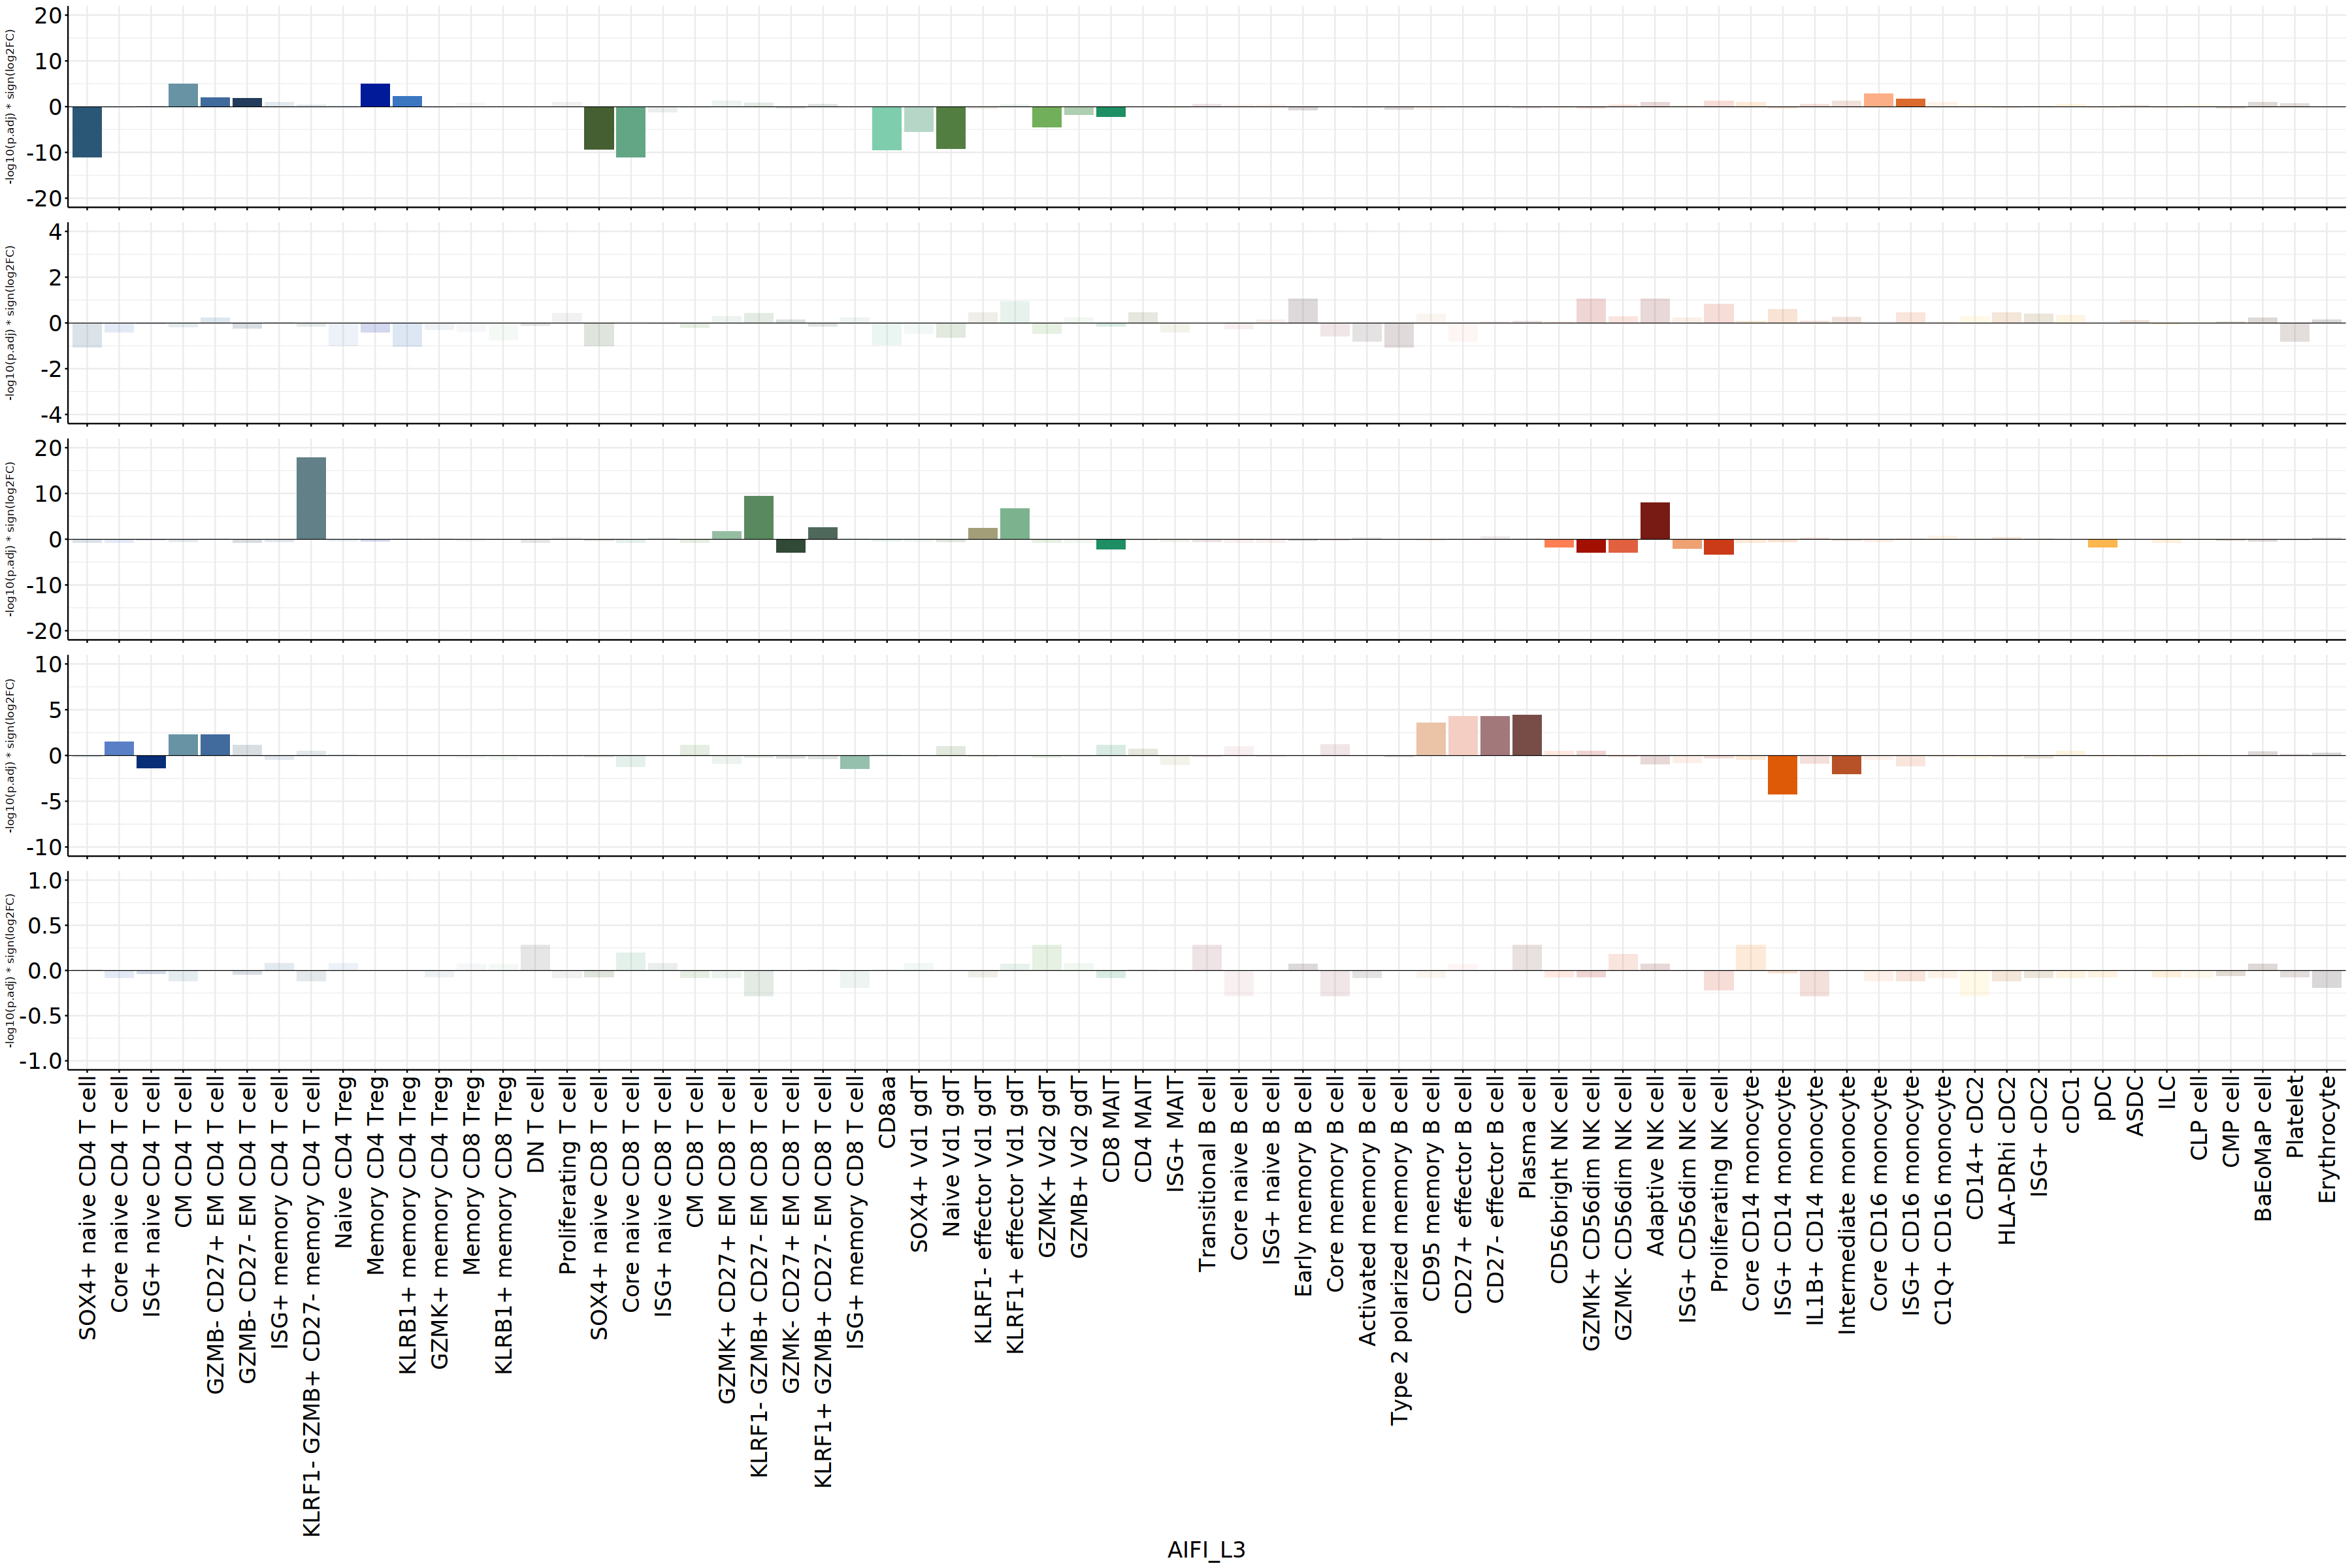

In [455]:
stacked_plots

# Generating Freq table - cross sectional(wetbench)

In [463]:
dim(l3_filt)
head(l3_filt)
colnames(l3_filt)

[1] 6275   26

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L3                
1 32                     KT00001              ⋯ CD27+ effector B cell  
2 32                     KT00001              ⋯ CD27- effector B cell  
3 32                     KT00001              ⋯ Activated memory B cell
4 32                     KT00001              ⋯ CD95 memory B cell     
5 32                     KT00001              ⋯ Core memory B cell     
6 32                     KT00001              ⋯ Early memory B cell    
  AIFI_L3_count total_cells scrna.lymphocyte_count bc.lymphocyte_count
1  71           18231       13903                  1337               
2  26           18231       13903                  1337               
3   3           18231       13903                  1337               
4  15           18231       13903                  1337               
5 329           18231       13903                  1337               
6  10           18231       13903                  1337               
  alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr percentage
1 0.0961663 0.0038944655        6.8278069   0.3324226  0.38944655
2 0.0961663 0.0014261423        2.5003237  -0.6721608  0.14261423
3 0.0961663 0.0001645549        0.2884989  -2.8316450  0.01645549
4 0.0961663 0.0008227744        1.4424944  -1.2222071  0.08227744
5 0.0961663 0.0180461851       31.6387111   1.8658004  1.80461851
6 0.0961663 0.0005485163        0.9616630  -1.6276722  0.05485163

[1] "cohort.cohortGuid"       "subject.subjectGuid"    
 [3] "subject.biologicalSex"   "subject.cmv"            
 [5] "subject.bmi"             "subject.race"           
 [7] "subject.ethnicity"       "subject.birthYear"      
 [9] "subject.ageAtFirstDraw"  "sample.sampleKitGuid"   
[11] "sample.visitName"        "sample.drawDate"        
[13] "sample.subjectAgeAtDraw" "specimen.specimenGuid"  
[15] "AIFI_L1"                 "AIFI_L2"                
[17] "AIFI_L3"                 "AIFI_L3_count"          
[19] "total_cells"             "scrna.lymphocyte_count" 
[21] "bc.lymphocyte_count"     "alc_ratio"              
[23] "AIFI_L3_frac_total"      "AIFI_L3_alc"            
[25] "AIFI_L3_clr"             "percentage"

In [466]:
# Pivot the dataframe from long to wide format
wet_freq <- l3_filt %>%
  pivot_wider(
    id_cols = c(cohort.cohortGuid,subject.subjectGuid, subject.cmv, specimen.specimenGuid, subject.biologicalSex, subject.birthYear, subject.ethnicity, subject.race, sample.visitName),   # Columns to keep as is
    names_from = AIFI_L3,          # Column to pivot from
    values_from = percentage       # Column to pivot to values
  )


In [467]:
head(wet_freq)

cohort.cohortGuid subject.subjectGuid subject.cmv specimen.specimenGuid
1 BR1               BR1001              Negative    PB00001-01           
2 BR1               BR1002              Negative    PB00002-01           
3 BR1               BR1003              Negative    PB00003-01           
4 BR1               BR1004              Negative    PB00004-01           
5 BR1               BR1005              Negative    PB00006-01           
6 BR1               BR1006              Negative    PB00010-02           
  subject.biologicalSex subject.birthYear subject.ethnicity   subject.race
1 Female                1987              Non-Hispanic origin Caucasian   
2 Male                  1991              Non-Hispanic origin Caucasian   
3 Female                1989              Non-Hispanic origin Caucasian   
4 Male                  1989              Non-Hispanic origin Caucasian   
5 Female                1992              Non-Hispanic origin Caucasian   
6 Male                  1988              Non-Hispanic origin Caucasian   
  sample.visitName CD27+ effector B cell ⋯ KLRB1+ memory CD8 Treg
1 Flu Year 1 Day 0 0.3894465             ⋯ 0.05485163            
2 Flu Year 1 Day 0 0.1407182             ⋯ 0.05065856            
3 Flu Year 1 Day 0 0.2182244             ⋯ 0.01596764            
4 Flu Year 1 Day 0 0.2670782             ⋯ 0.01187014            
5 Flu Year 1 Day 0 0.1025641             ⋯ 0.03418803            
6 Flu Year 1 Day 0 0.2154670             ⋯ 0.01164687            
  Memory CD4 Treg Memory CD8 Treg Naive CD4 Treg GZMB+ Vd2 gdT GZMK+ Vd2 gdT
1 0.8392299       0.032910976     0.7295266      0.7624376     1.0312106    
2 0.8049083       0.084430935     1.3058651      0.7317348     1.3565237    
3 0.7664467       0.005322546     0.7877369      0.2075793     0.7185438    
4 1.1217283       0.017805211     1.3057155      1.2107543     3.5847825    
5 1.2136752       0.034188034     1.0712251      0.5527066     0.7920228    
6 0.5532262       0.005823433     0.6638714      2.3060797     2.1080829    
  KLRF1+ effector Vd1 gdT KLRF1- effector Vd1 gdT Naive Vd1 gdT SOX4+ Vd1 gdT
1 0.010970325             0.03291098              0.19746585    0.04388130   
2 0.050658561             0.02251492              0.18574806    0.03940110   
3 0.005322546                     NA              0.51096445    0.22354694   
4 0.261143095                     NA              0.10683127    0.01187014   
5 0.034188034             0.04558405              0.07977208    0.03418803   
6 0.017470300                     NA              0.15723270    0.01747030

In [468]:
write.csv(wet_freq, file = "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/CSVs/Frequency_Percentage_byDonor_wetbench.csv", row.names = TRUE)

# Generating Freq table - Logitudinal(wetbench) 

In [479]:
l3_long <- l3 %>% filter(sample.visitName %in% c('Flu Year 1 Day 0', 'Flu Year 1 Day 7'))
l3_long <- l3_long %>% dplyr::mutate(percentage = (AIFI_L3_frac_total * 100))

In [480]:
## Percentage of total

result <- l3_long %>% select(AIFI_L3, subject.subjectGuid, sample.visitName, AIFI_L3_count, percentage)
  # dplyr::group_by(AIFI_L3, subject.subjectGuid,sample.visitName ) %>%               
  # dplyr::summarise(count = n()) %>%                  # Count occurrences
  # dplyr::group_by(subject.subjectGuid, sample.visitName) %>%                       
  # dplyr::mutate(percentage = (count / sum(count)) * 100) 
  

head(result)
dim(result)
#sum(result$subject.subjectGuid)

AIFI_L3                 subject.subjectGuid sample.visitName AIFI_L3_count
1 CD27+ effector B cell   BR1001              Flu Year 1 Day 0  71          
2 CD27- effector B cell   BR1001              Flu Year 1 Day 0  26          
3 Activated memory B cell BR1001              Flu Year 1 Day 0   3          
4 CD95 memory B cell      BR1001              Flu Year 1 Day 0  15          
5 Core memory B cell      BR1001              Flu Year 1 Day 0 329          
6 Early memory B cell     BR1001              Flu Year 1 Day 0  10          
  percentage
1 0.38944655
2 0.14261423
3 0.01645549
4 0.08227744
5 1.80461851
6 0.05485163

[1] 12554     5

In [481]:
wide_df <- l3_long %>%
  pivot_wider(
    id_cols = c(cohort.cohortGuid,subject.subjectGuid, sample.visitName, subject.cmv, specimen.specimenGuid, subject.biologicalSex, subject.birthYear, subject.ethnicity, subject.race),   # Columns to keep as is
    names_from = AIFI_L3,          # Column to pivot from
    values_from = percentage       # Column to pivot to values
  )

In [482]:
head(wide_df)

cohort.cohortGuid subject.subjectGuid sample.visitName subject.cmv
1 BR1               BR1001              Flu Year 1 Day 0 Negative   
2 BR1               BR1002              Flu Year 1 Day 0 Negative   
3 BR1               BR1003              Flu Year 1 Day 0 Negative   
4 BR1               BR1004              Flu Year 1 Day 0 Negative   
5 BR1               BR1005              Flu Year 1 Day 0 Negative   
6 BR1               BR1003              Flu Year 1 Day 7 Negative   
  specimen.specimenGuid subject.biologicalSex subject.birthYear
1 PB00001-01            Female                1987             
2 PB00002-01            Male                  1991             
3 PB00003-01            Female                1989             
4 PB00004-01            Male                  1989             
5 PB00006-01            Female                1992             
6 PB00007-01            Female                1989             
  subject.ethnicity   subject.race CD27+ effector B cell ⋯
1 Non-Hispanic origin Caucasian    0.3894465             ⋯
2 Non-Hispanic origin Caucasian    0.1407182             ⋯
3 Non-Hispanic origin Caucasian    0.2182244             ⋯
4 Non-Hispanic origin Caucasian    0.2670782             ⋯
5 Non-Hispanic origin Caucasian    0.1025641             ⋯
6 Non-Hispanic origin Caucasian    0.2783493             ⋯
  KLRB1+ memory CD8 Treg Memory CD4 Treg Memory CD8 Treg Naive CD4 Treg
1 0.05485163             0.8392299       0.032910976     0.7295266     
2 0.05065856             0.8049083       0.084430935     1.3058651     
3 0.01596764             0.7664467       0.005322546     0.7877369     
4 0.01187014             1.1217283       0.017805211     1.3057155     
5 0.03418803             1.2136752       0.034188034     1.0712251     
6 0.03630643             0.8713542       0.012102142     0.7382307     
  GZMB+ Vd2 gdT GZMK+ Vd2 gdT KLRF1+ effector Vd1 gdT KLRF1- effector Vd1 gdT
1 0.7624376     1.0312106     0.010970325             0.03291098             
2 0.7317348     1.3565237     0.050658561             0.02251492             
3 0.2075793     0.7185438     0.005322546                     NA             
4 1.2107543     3.5847825     0.261143095                     NA             
5 0.5527066     0.7920228     0.034188034             0.04558405             
6 0.1996853     0.6535157     0.006051071                     NA             
  Naive Vd1 gdT SOX4+ Vd1 gdT
1 0.19746585    0.04388130   
2 0.18574806    0.03940110   
3 0.51096445    0.22354694   
4 0.10683127    0.01187014   
5 0.07977208    0.03418803   
6 0.50828997    0.22994070

In [483]:
unique(wide_df$sample.visitName)

[1] "Flu Year 1 Day 0" "Flu Year 1 Day 7"

In [484]:
write.csv(wide_df, file = "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/CSVs/Frequency_Percentage_byDonor_FluYr1D0_D7_wetbench.csv", row.names = TRUE)

# Generating B cell frequencies for Mehul- Whole pbmc

In [22]:
samps <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/CSVs/filterB_formansi_y2only_d0_d7.csv")

In [23]:
# Extract the column you want to format
column_values <- samps$pbmc_sample_id

# Create a character vector with each value enclosed in double quotes
formatted_values <- paste0("\"", column_values, "\"")

# Combine the values into a single string separated by a comma
formatted_string <- paste(formatted_values, collapse = ", ")

formatted_string

[1] "\"PB02337-001\", \"PB02338-001\", \"PB02339-001\", \"PB02340-001\", \"PB02341-001\", \"PB02343-001\", \"PB02344-001\", \"PB02346-001\", \"PB02347-001\", \"PB02348-001\", \"PB02349-001\", \"PB02350-001\", \"PB02351-001\", \"PB02352-001\", \"PB02353-001\", \"PB02354-001\", \"PB02355-001\", \"PB02356-001\", \"PB02357-001\", \"PB02358-001\", \"PB02444-001\", \"PB02445-001\", \"PB02446-001\", \"PB02447-001\", \"PB02449-001\", \"PB02450-001\", \"PB02451-001\", \"PB02452-001\", \"PB02453-001\", \"PB02454-001\", \"PB02455-001\", \"PB02456-001\", \"PB02457-001\", \"PB02458-001\", \"PB02459-001\", \"PB02460-001\", \"PB02461-001\", \"PB02462-001\", \"PB02463-001\", \"PB02464-001\", \"PB02465-001\", \"PB02466-001\", \"PB02467-001\", \"PB02468-001\", \"PB02469-001\", \"PB02470-001\", \"PB02472-001\", \"PB02473-001\", \"PB02474-002\", \"PB02475-001\", \"PB02476-001\", \"PB02477-001\", \"PB02478-001\", \"PB02479-001\", \"PB02481-001\", \"PB02483-001\", \"PB02484-001\", \"PB02485-001\", \"PB02486-001\", \"PB02488-002\", \"PB02489-001\", \"PB02490-001\", \"PB02491-001\", \"PB02492-001\", \"PB02493-001\", \"PB02494-001\", \"PB02495-001\", \"PB02496-001\", \"PB02497-001\", \"PB02498-001\", \"PB02499-001\", \"PB02500-001\", \"PB02501-002\", \"PB02502-001\", \"PB02503-001\", \"PB02504-001\", \"PB02505-002\", \"PB02506-001\", \"PB02507-001\", \"PB02508-001\", \"PB02509-001\", \"PB02510-001\", \"PB02511-001\", \"PB02512-001\", \"PB02513-001\", \"PB02514-001\", \"PB02515-002\", \"PB02516-001\", \"PB02517-001\", \"PB02518-001\", \"PB02521-001\", \"PB02522-002\", \"PB02523-001\", \"PB02524-001\", \"PB02525-001\", \"PB02526-001\", \"PB02527-002\", \"PB02528-001\", \"PB02529-001\", \"PB02530-001\", \"PB02531-002\", \"PB02532-001\", \"PB02533-001\", \"PB02534-001\", \"PB02535-001\", \"PB02536-001\", \"PB02537-001\", \"PB02538-002\", \"PB02540-001\", \"PB02541-001\", \"PB02542-001\", \"PB02543-001\", \"PB02544-001\", \"PB02545-001\", \"PB02546-002\", \"PB02547-001\", \"PB02548-001\", \"PB02551-001\", \"PB02552-001\", \"PB02554-002\", \"PB02555-001\", \"PB02556-002\", \"PB02557-002\", \"PB02561-001\", \"PB02562-001\", \"PB02563-001\", \"PB02564-001\", \"PB02565-001\", \"PB02566-001\", \"PB02568-001\", \"PB02571-001\", \"PB02578-001\", \"PB02590-001\", \"PB03074-001\", \"PB03083-001\", \"PB03091-001\""

In [40]:
selected_samples <- c("PB02337-001", "PB02338-001", "PB02339-001", "PB02340-001", "PB02341-001",
                      "PB02343-001", "PB02344-001", "PB02346-001", "PB02347-001", "PB02348-001", 
                      "PB02349-001", "PB02350-001", "PB02351-001", "PB02352-001", "PB02353-001", 
                      "PB02354-001", "PB02355-001", "PB02356-001", "PB02357-001", "PB02358-001",
                      "PB02444-001", "PB02445-001", "PB02446-001", "PB02447-001", "PB02449-001",
                      "PB02450-001", "PB02451-001", "PB02452-001", "PB02453-001", "PB02454-001",
                      "PB02455-001", "PB02456-001", "PB02457-001", "PB02458-001", "PB02459-001",
                      "PB02460-001", "PB02461-001", "PB02462-001", "PB02463-001", "PB02464-001", 
                      "PB02465-001", "PB02466-001", "PB02467-001", "PB02468-001", "PB02469-001",
                      "PB02470-001", "PB02472-001", "PB02473-001", "PB02474-002", "PB02475-001", 
                      "PB02476-001", "PB02477-001", "PB02478-001", "PB02479-001", "PB02481-001",
                      "PB02483-001", "PB02484-001", "PB02485-001", "PB02486-001", "PB02488-002", 
                      "PB02489-001", "PB02490-001", "PB02491-001", "PB02492-001", "PB02493-001", 
                      "PB02494-001", "PB02495-001", "PB02496-001", "PB02497-001", "PB02498-001",
                      "PB02499-001", "PB02500-001", "PB02501-002", "PB02502-001", "PB02503-001",
                      "PB02504-001", "PB02505-002", "PB02506-001", "PB02507-001", "PB02508-001", 
                      "PB02509-001", "PB02510-001", "PB02511-001", "PB02512-001", "PB02513-001",
                      "PB02514-001", "PB02515-002", "PB02516-001", "PB02517-001", "PB02518-001",
                      "PB02521-001", "PB02522-002", "PB02523-001", "PB02524-001", "PB02525-001",
                      "PB02526-001", "PB02527-002", "PB02528-001", "PB02529-001", "PB02530-001", 
                      "PB02531-002", "PB02532-001", "PB02533-001", "PB02534-001", "PB02535-001",
                      "PB02536-001", "PB02537-001", "PB02538-002", "PB02540-001", "PB02541-001",
                      "PB02542-001", "PB02543-001", "PB02544-001", "PB02545-001", "PB02546-002", 
                      "PB02547-001", "PB02548-001", "PB02551-001", "PB02552-001", "PB02554-002",
                      "PB02555-001", "PB02556-002", "PB02557-002", "PB02561-001", "PB02562-001",
                      "PB02563-001", "PB02564-001", "PB02565-001", "PB02566-001", "PB02568-001",
                      "PB02571-001", "PB02578-001", "PB02590-001", "PB03074-001", "PB03083-001", "PB03091-001")

In [41]:
length(selected_samples)

[1] 136

In [35]:
## create a percentage column
l3_bcells <- l3%>% dplyr::mutate(percentage = (AIFI_L3_frac_total * 100))

In [36]:
bcell_freq <- l3_bcells %>% 
  filter(specimen.specimenGuid %in% selected_samples)


In [28]:
# filtered_data <- bcell_freq %>%
#   group_by(AIFI_L3,subject.subjectGuid) %>%
#   filter(all(c("Flu Year 1 Day 0", "Flu Year 1 Day 7") %in% sample.visitName))
# head(filtered_data)

In [29]:
# filtered_data %>%
#   group_by(AIFI_L3, sample.visitName) %>%
#   dplyr::summarize(n = n())


In [42]:
# head(bcell_freq)
# length(unique(bcell_freq$specimen.specimenGuid))
unique(bcell_freq$sample.visitName)
# dim(bcell_freq)

[1] "Flu Year 2 Day 0" "Flu Year 2 Day 7"

In [37]:
selected_celltypes <- c ('SOX4+ naive CD4 T cell','Core naive CD4 T cell','ISG+ naive CD4 T cell','CM CD4 T cell','GZMB- CD27+ EM CD4 T cell',
                         'GZMB- CD27- EM CD4 T cell','ISG+ memory CD4 T cell','KLRF1- GZMB+ CD27- memory CD4 T cell', 'CD27+ effector B cell',
                         'CD27- effector B cell','Activated memory B cell','CD95 memory B cell','Core memory B cell','Early memory B cell',
                         'Type 2 polarized memory B cell','Core naive B cell','ISG+ naive B cell','Plasma cell','Transitional B cell') 

In [38]:
subset_data1 <- bcell_freq %>% filter(AIFI_L3 %in% selected_celltypes & cohort.cohortGuid == "BR1")
subset_data2 <- bcell_freq %>% filter(AIFI_L3 %in% selected_celltypes & cohort.cohortGuid == "BR2")

write.csv(subset_data1, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/CSVs/subset_BR1_B_CD4_Tcells_wholepbmc_y2.csv")
write.csv(subset_data2, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/CSVs/subset_BR2_B_CD4_Tcells_wholepbmc_y2.csv")

In [596]:
subset_data1  %>% head()
colnames(subset_data1)
unique(subset_data1$AIFI_L3)
unique(subset_data1$cohort.cohortGuid)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1021              Female                Negative   
2 BR1               BR1021              Female                Negative   
3 BR1               BR1021              Female                Negative   
4 BR1               BR1021              Female                Negative   
5 BR1               BR1021              Female                Negative   
6 BR1               BR1021              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 24          Caucasian    Non-Hispanic origin 1986             
2 24          Caucasian    Non-Hispanic origin 1986             
3 24          Caucasian    Non-Hispanic origin 1986             
4 24          Caucasian    Non-Hispanic origin 1986             
5 24          Caucasian    Non-Hispanic origin 1986             
6 24          Caucasian    Non-Hispanic origin 1986             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L3                
1 34                     KT00338              ⋯ CD27+ effector B cell  
2 34                     KT00338              ⋯ CD27- effector B cell  
3 34                     KT00338              ⋯ Activated memory B cell
4 34                     KT00338              ⋯ CD95 memory B cell     
5 34                     KT00338              ⋯ Core memory B cell     
6 34                     KT00338              ⋯ Early memory B cell    
  AIFI_L3_count total_cells scrna.lymphocyte_count bc.lymphocyte_count
1  49           12935       10150                  1806               
2  26           12935       10150                  1806               
3   3           12935       10150                  1806               
4  13           12935       10150                  1806               
5 430           12935       10150                  1806               
6  11           12935       10150                  1806               
  alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr percentage
1 0.177931  0.0037881716        8.7186207   0.3802135  0.37881716
2 0.177931  0.0020100503        4.6262069  -0.2535103  0.20100503
3 0.177931  0.0002319289        0.5337931  -2.4129945  0.02319289
4 0.177931  0.0010050251        2.3131034  -0.9466575  0.10050251
5 0.177931  0.0332431388       76.5103448   2.5521784  3.32431388
6 0.177931  0.0008504059        1.9572414  -1.1137115  0.08504059

[1] "cohort.cohortGuid"       "subject.subjectGuid"    
 [3] "subject.biologicalSex"   "subject.cmv"            
 [5] "subject.bmi"             "subject.race"           
 [7] "subject.ethnicity"       "subject.birthYear"      
 [9] "subject.ageAtFirstDraw"  "sample.sampleKitGuid"   
[11] "sample.visitName"        "sample.drawDate"        
[13] "sample.subjectAgeAtDraw" "specimen.specimenGuid"  
[15] "AIFI_L1"                 "AIFI_L2"                
[17] "AIFI_L3"                 "AIFI_L3_count"          
[19] "total_cells"             "scrna.lymphocyte_count" 
[21] "bc.lymphocyte_count"     "alc_ratio"              
[23] "AIFI_L3_frac_total"      "AIFI_L3_alc"            
[25] "AIFI_L3_clr"             "percentage"

[1] "CD27+ effector B cell"               
 [2] "CD27- effector B cell"               
 [3] "Activated memory B cell"             
 [4] "CD95 memory B cell"                  
 [5] "Core memory B cell"                  
 [6] "Early memory B cell"                 
 [7] "Type 2 polarized memory B cell"      
 [8] "Core naive B cell"                   
 [9] "ISG+ naive B cell"                   
[10] "Plasma cell"                         
[11] "Transitional B cell"                 
[12] "CM CD4 T cell"                       
[13] "GZMB- CD27+ EM CD4 T cell"           
[14] "GZMB- CD27- EM CD4 T cell"           
[15] "ISG+ memory CD4 T cell"              
[16] "KLRF1- GZMB+ CD27- memory CD4 T cell"
[17] "Core naive CD4 T cell"               
[18] "ISG+ naive CD4 T cell"               
[19] "SOX4+ naive CD4 T cell"

[1] "BR1"

In [556]:
subset_data1 <- subset_data1 %>%
  group_by(AIFI_L3,subject.subjectGuid) %>%
  filter(all(c("Flu Year 1 Day 0", "Flu Year 1 Day 7") %in% sample.visitName))

In [557]:
subset_data1 %>%
  group_by(AIFI_L3, sample.visitName) %>%
  dplyr::summarize(n = n())

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3                        sample.visitName n 
1  Activated memory B cell        Flu Year 1 Day 0 19
2  Activated memory B cell        Flu Year 1 Day 7 19
3  CD27+ effector B cell          Flu Year 1 Day 0 26
4  CD27+ effector B cell          Flu Year 1 Day 7 26
5  CD27- effector B cell          Flu Year 1 Day 0 26
6  CD27- effector B cell          Flu Year 1 Day 7 26
7  CD95 memory B cell             Flu Year 1 Day 0 26
8  CD95 memory B cell             Flu Year 1 Day 7 26
9  Core memory B cell             Flu Year 1 Day 0 26
10 Core memory B cell             Flu Year 1 Day 7 26
11 Core naive B cell              Flu Year 1 Day 0 26
12 Core naive B cell              Flu Year 1 Day 7 26
13 Early memory B cell            Flu Year 1 Day 0 26
14 Early memory B cell            Flu Year 1 Day 7 26
15 ISG+ naive B cell              Flu Year 1 Day 0 26
16 ISG+ naive B cell              Flu Year 1 Day 7 26
17 Plasma cell                    Flu Year 1 Day 0 25
18 Plasma cell                    Flu Year 1 Day 7 25
19 Transitional B cell            Flu Year 1 Day 0 26
20 Transitional B cell            Flu Year 1 Day 7 26
21 Type 2 polarized memory B cell Flu Year 1 Day 0 26
22 Type 2 polarized memory B cell Flu Year 1 Day 7 26

In [567]:
head(subset_data1)
dim(subset_data1)
dim(subset_data2)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1021              Female                Negative   
2 BR1               BR1021              Female                Negative   
3 BR1               BR1021              Female                Negative   
4 BR1               BR1021              Female                Negative   
5 BR1               BR1021              Female                Negative   
6 BR1               BR1021              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 24          Caucasian    Non-Hispanic origin 1986             
2 24          Caucasian    Non-Hispanic origin 1986             
3 24          Caucasian    Non-Hispanic origin 1986             
4 24          Caucasian    Non-Hispanic origin 1986             
5 24          Caucasian    Non-Hispanic origin 1986             
6 24          Caucasian    Non-Hispanic origin 1986             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L3                
1 34                     KT00338              ⋯ CD27+ effector B cell  
2 34                     KT00338              ⋯ CD27- effector B cell  
3 34                     KT00338              ⋯ Activated memory B cell
4 34                     KT00338              ⋯ CD95 memory B cell     
5 34                     KT00338              ⋯ Core memory B cell     
6 34                     KT00338              ⋯ Early memory B cell    
  AIFI_L3_count total_cells scrna.lymphocyte_count bc.lymphocyte_count
1  49           12935       10150                  1806               
2  26           12935       10150                  1806               
3   3           12935       10150                  1806               
4  13           12935       10150                  1806               
5 430           12935       10150                  1806               
6  11           12935       10150                  1806               
  alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr percentage
1 0.177931  0.0037881716        8.7186207   0.3802135  0.37881716
2 0.177931  0.0020100503        4.6262069  -0.2535103  0.20100503
3 0.177931  0.0002319289        0.5337931  -2.4129945  0.02319289
4 0.177931  0.0010050251        2.3131034  -0.9466575  0.10050251
5 0.177931  0.0332431388       76.5103448   2.5521784  3.32431388
6 0.177931  0.0008504059        1.9572414  -1.1137115  0.08504059

[1] 556  26

[1] 906  26

In [572]:
unique(subset_data1$AIFI_L3)

[1] "CD27+ effector B cell"          "CD27- effector B cell"         
 [3] "Activated memory B cell"        "CD95 memory B cell"            
 [5] "Core memory B cell"             "Early memory B cell"           
 [7] "Type 2 polarized memory B cell" "Core naive B cell"             
 [9] "ISG+ naive B cell"              "Plasma cell"                   
[11] "Transitional B cell"

In [561]:
stat_test_2 <- subset_data1 %>%
  select(percentage, AIFI_L3_clr, AIFI_L3, cohort.cohortGuid, subject.cmv, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid) %>%
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")



In [591]:
stat_test <- subset_data1 %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid) %>%
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
 add_xy_position(x = "AIFI_L3", fun = "max")
  
stat_test

ERROR while rich displaying an object: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 11, 2

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.d

In [588]:
library(rstatix)

In [563]:
library(rstatix)

stat_test_2 <- subset_data1 %>%
  select(percentage, AIFI_L3_clr, AIFI_L3, cohort.cohortGuid, subject.cmv, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>% 
  arrange(subject.subjectGuid) %>%
  as.data.frame() %>%   # Convert to data frame
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
    add_xy_position(x = as.numeric(AIFI_L3), fun = "max")
  add_xy_position(x = "AIFI_L3", fun = "max")


In [564]:
stat_test_2

Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”


.y.        group1           group2           n1  n2  statistic p       
1 percentage Flu Year 1 Day 0 Flu Year 1 Day 7 278 278 12264     1.09e-07
2 percentage Flu Year 1 Day 0 Flu Year 1 Day 7 278 278 12264     1.09e-07
  p.adj    p.adj.signif y.position groups           xmin xmax
1 1.09e-07 ****         14.2552    Flu Year 1 Day 0 NA   NA  
2 1.09e-07 ****         14.2552    Flu Year 1 Day 7 NA   NA

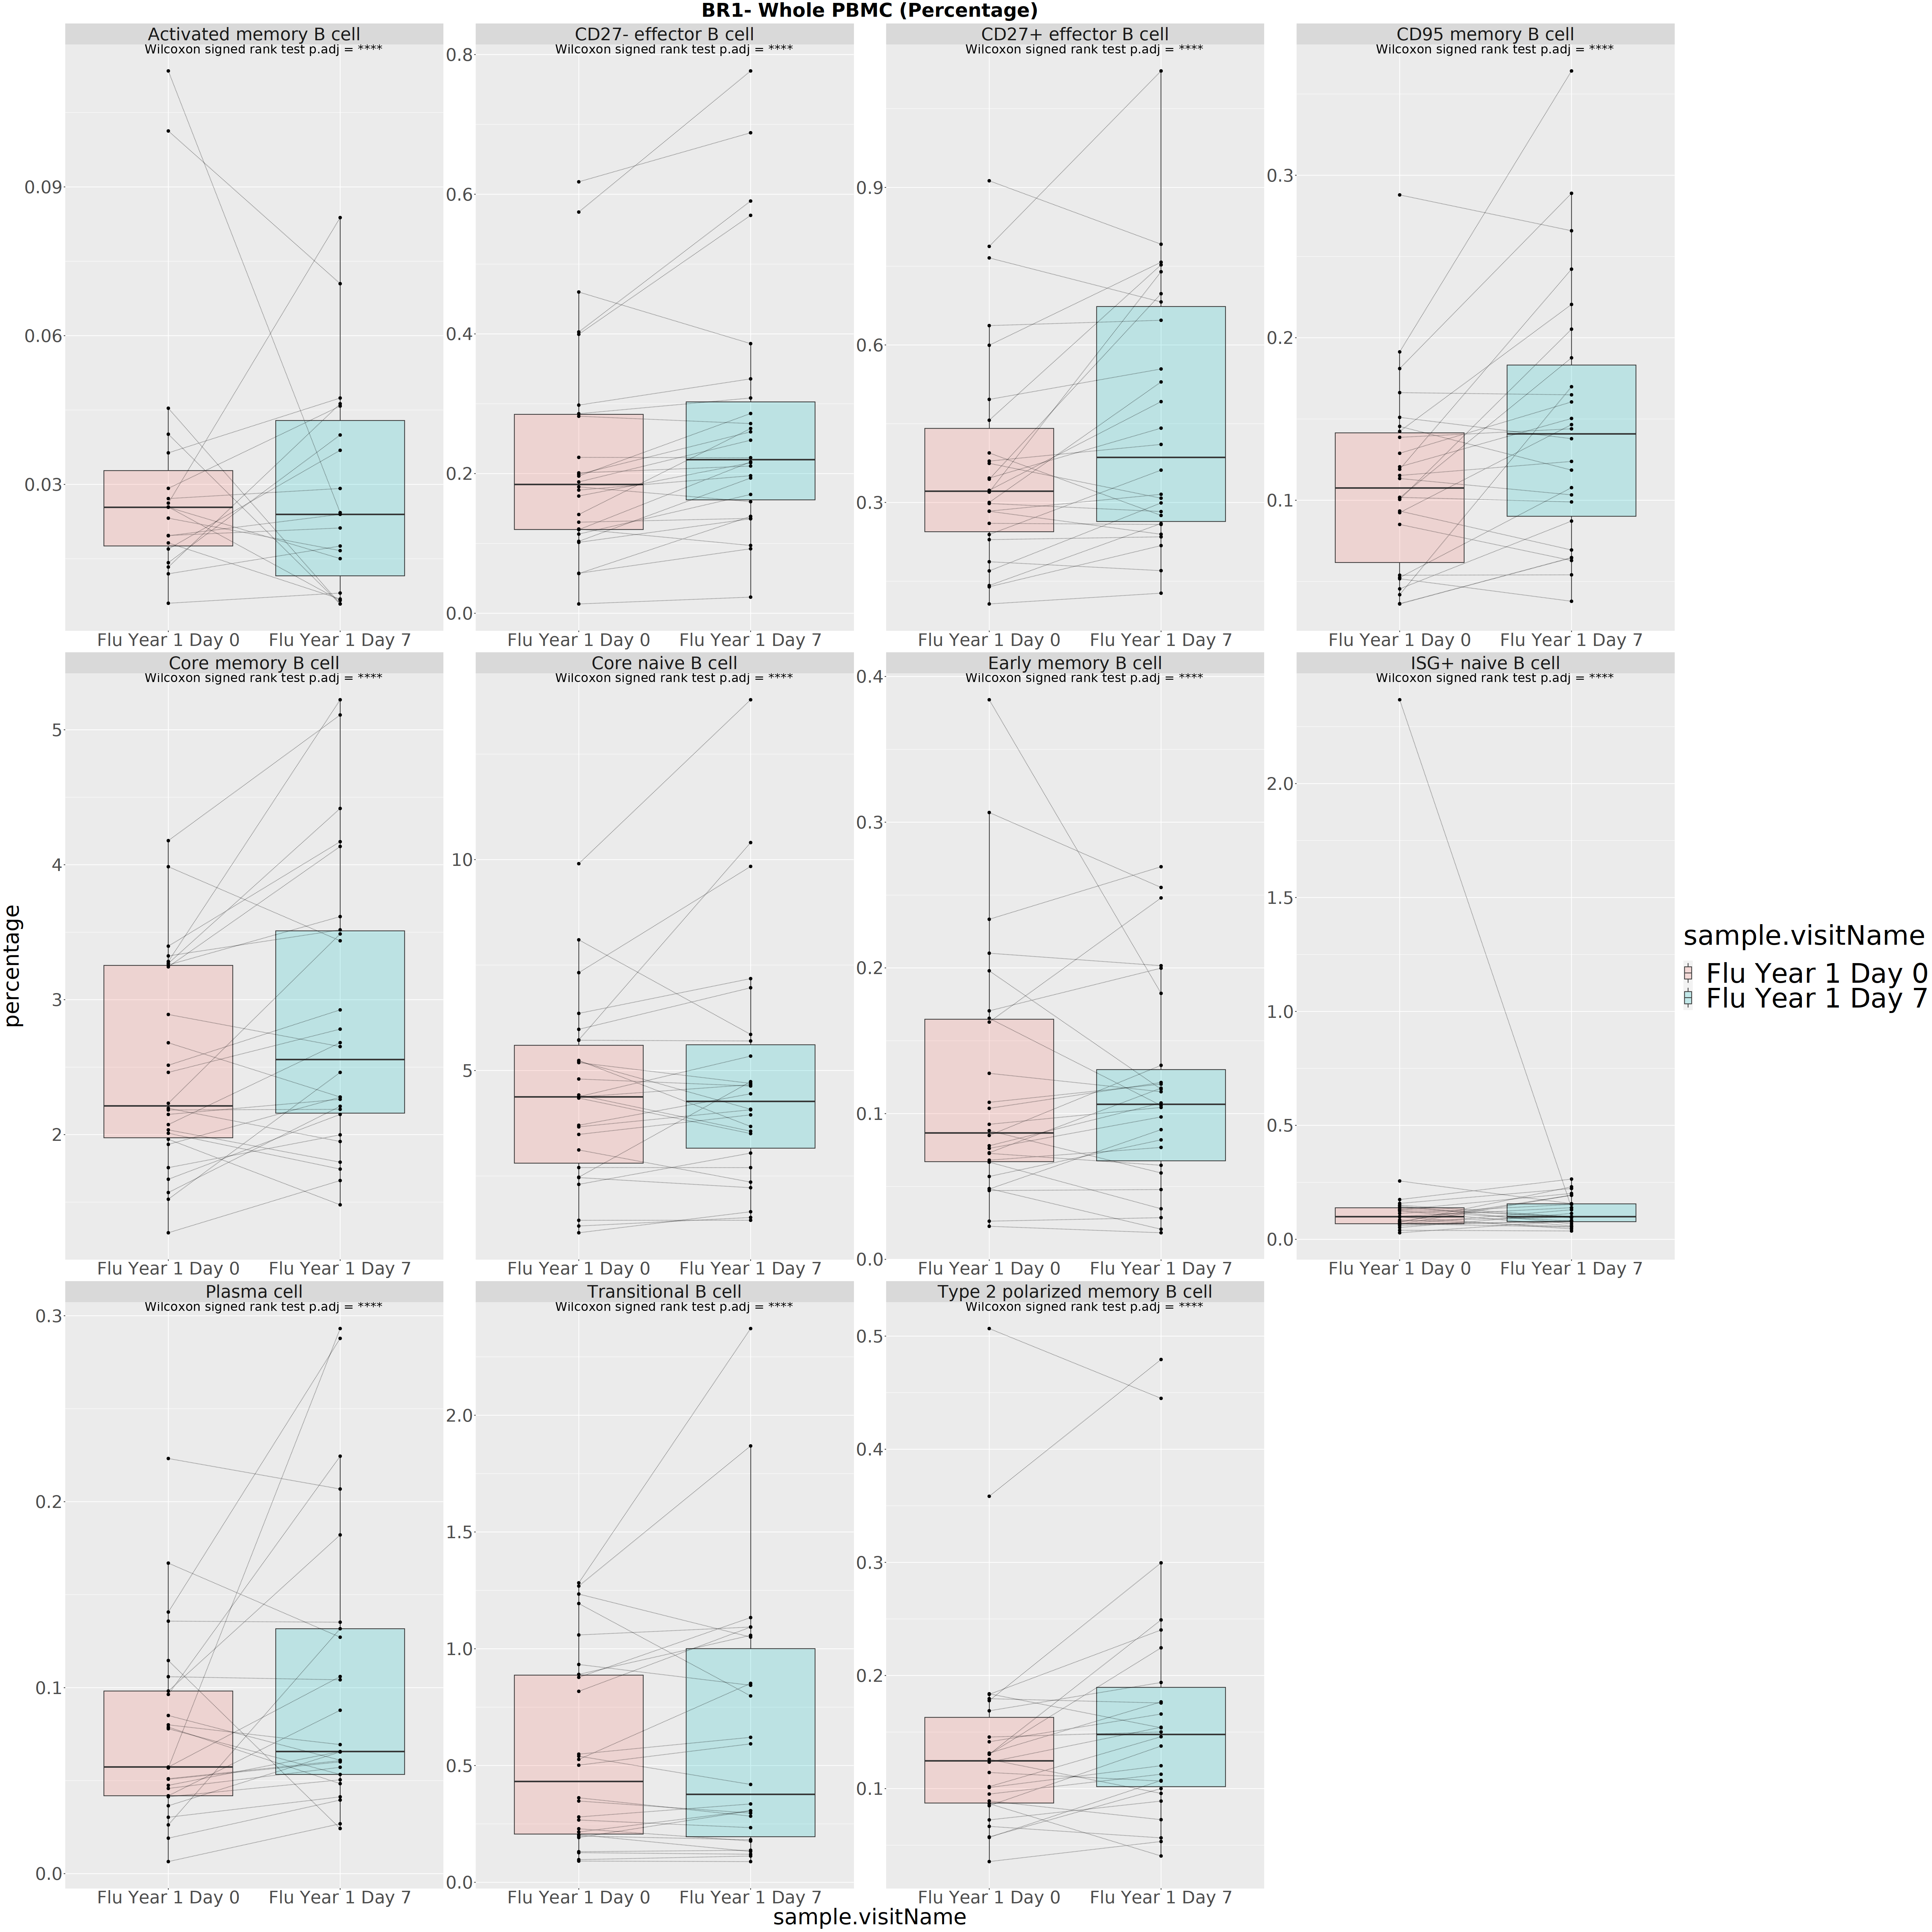

In [565]:
# subset fro B cell and monocytes,  Perform Wilcoxon signed-rank test
# Y-scale : percentage


#subset BR1
# subset_data1 <- merged_df %>%
#   filter(AIFI_L1 == "B cell" & cohort.cohortGuid == "BR1")

stat_test_1 <- subset_data1 %>%
  select(percentage, AIFI_L3_clr, AIFI_L3, cohort.cohortGuid, subject.cmv, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>% 
  arrange(subject.subjectGuid) %>%
  as.data.frame() %>%   # Convert to data frame
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")

# Create the base plot with modified theme settings
p1 <- ggplot(subset_data1, aes(x = sample.visitName, y = percentage)) + 
  geom_boxplot(aes(fill = sample.visitName), alpha = .2, ) +  # Faint gray and dotted line color
  geom_line(aes(group = subject.subjectGuid), color = "black", linetype = "dotted") + 
  geom_point(size = 2) + 
  facet_wrap(~ AIFI_L3, scales = "free", drop= FALSE) +
  theme(
    text = element_text(size = 40, color= "black"),  # Increase font size for all text elements
    axis.title = element_text(size = 40),  # Increase font size for axis titles
    legend.title = element_text(size = 50),  # Increase font size for legend title
    legend.text = element_text(size = 50)  # Increase font size for legend text
  ) + labs(y = "percentage")

# Add p-values to the plot
options(repr.plot.width = 50, repr.plot.height = 50)
p1 + geom_text(data = stat_test_1, aes(label = paste("Wilcoxon signed rank test p.adj =", p.adj.signif)),  
              x = 1, y = Inf, hjust = 0.1, vjust = 1, size = 8, color = "black") + ggtitle("BR1- Whole PBMC (Percentage)") + theme(plot.title = element_text(size = 35, hjust = 0.5, face = "bold"))  # Centered and larger p-value text

#subset BR2
subset_data2 <- merged_df %>%
  filter(AIFI_L1 == "B cell" & cohort.cohortGuid == "BR2")

stat_test_2 <- subset_data2 %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")

# Create the base plot with modified theme settings
p1 <- ggplot(subset_data2, aes(x = sample.visitName, y = percentage)) + 
  geom_boxplot(aes(fill = sample.visitName), alpha = .2, ) +  # Faint gray and dotted line color
  geom_line(aes(group = subject.subjectGuid), color = "black", linetype = "dotted") + 
  geom_point(size = 2) + 
  facet_wrap(~ AIFI_L3, scales = "free", drop= FALSE) +
  theme(
    text = element_text(size = 40, color= "black"),  # Increase font size for all text elements
    axis.title = element_text(size = 40),  # Increase font size for axis titles
    legend.title = element_text(size = 50),  # Increase font size for legend title
    legend.text = element_text(size = 50)  # Increase font size for legend text
  ) + labs(y = "percentage")

# Add p-values to the plot
options(repr.plot.width = 50, repr.plot.height = 50)
p1 + geom_text(data = stat_test_2, aes(label = paste("Wilcoxon signed rank test p.adj =", p.adj.signif)),  
              x = 1, y = Inf, hjust = 0.1, vjust = 1, size = 8, color = "black") + ggtitle("BR2- Whole PBMC (Percentage)") + theme(plot.title = element_text(size = 35, hjust = 0.5, face = "bold")) # Centered and larger p-value text


In [ ]:
# subset fro B cell and monocytes,  Perform Wilcoxon signed-rank test
# Y-scale : percentage _CLR

library(dplyr)

#subset BR1
subset_data1 <- merged_df %>%
  filter(AIFI_L1 == "B cell" & cohort.cohortGuid == "BR1")


stat_test_1 <- subset_data1 %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")

# Create the base plot with modified theme settings
p1 <- ggplot(subset_data1, aes(x = sample.visitName, y = percentage_clr)) + 
  geom_boxplot(aes(fill = sample.visitName), alpha = .2, ) +  # Faint gray and dotted line color
  geom_line(aes(group = subject.subjectGuid), color = "black", linetype = "dotted") + 
  geom_point(size = 2) + 
  facet_wrap(~ AIFI_L3, scales = "free", drop= FALSE) +
  theme(
    text = element_text(size = 40, color= "black"),  # Increase font size for all text elements
    axis.title = element_text(size = 40),  # Increase font size for axis titles
    legend.title = element_text(size = 50),  # Increase font size for legend title
    legend.text = element_text(size = 50)  # Increase font size for legend text
  ) + labs(y = "CLR")

# Add p-values to the plot
p1 + geom_text(data = stat_test_1, aes(label = paste("Wilcoxon signed rank test p.adj =", p.adj.signif)),  
              x = 1, y = Inf, hjust = 0.1, vjust = 1, size = 8, color = "black")+ ggtitle("BR1- Whole PBMC (CLR)") + theme(plot.title = element_text(size = 35, hjust = 0.5, face = "bold"))  # Centered and larger p-value text


#subset BR2
subset_data2 <- merged_df %>%
  filter(AIFI_L1 == "B cell" & cohort.cohortGuid == "BR2")


stat_test_2 <- subset_data2 %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")

# Create the base plot with modified theme settings
p2 <- ggplot(subset_data2, aes(x = sample.visitName, y = percentage_clr)) + 
  geom_boxplot(aes(fill = sample.visitName), alpha = .2, ) +  # Faint gray and dotted line color
  geom_line(aes(group = subject.subjectGuid), color = "black", linetype = "dotted") + 
  geom_point(size = 2) + 
  facet_wrap(~ AIFI_L3, scales = "free", drop= FALSE) +
  theme(
    text = element_text(size = 40, color= "black"),  # Increase font size for all text elements
    axis.title = element_text(size = 40),  # Increase font size for axis titles
    legend.title = element_text(size = 50),  # Increase font size for legend title
    legend.text = element_text(size = 50)  # Increase font size for legend text
  ) + labs(y = "CLR")

# Add p-values to the plot
p2 + geom_text(data = stat_test_2, aes(label = paste("Wilcoxon signed rank test p.adj =", p.adj.signif)),  
              x = 1, y = Inf, hjust = 0.1, vjust = 1, size = 8, color = "black") + ggtitle("BR2- Whole PBMC (CLR)") + theme(plot.title = element_text(size = 35, hjust = 0.5, face = "bold")) # Centered and larger p-value text


# Generating B cell frequencies for Mehul- Parent B cells

In [41]:
head(l3)
dim(l3)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L2        
1 32                     KT00001              ⋯ Effector B cell
2 32                     KT00001              ⋯ Effector B cell
3 32                     KT00001              ⋯ Memory B cell  
4 32                     KT00001              ⋯ Memory B cell  
5 32                     KT00001              ⋯ Memory B cell  
6 32                     KT00001              ⋯ Memory B cell  
  AIFI_L3                 AIFI_L3_count total_cells scrna.lymphocyte_count
1 CD27+ effector B cell    71           18231       13903                 
2 CD27- effector B cell    26           18231       13903                 
3 Activated memory B cell   3           18231       13903                 
4 CD95 memory B cell       15           18231       13903                 
5 Core memory B cell      329           18231       13903                 
6 Early memory B cell      10           18231       13903                 
  bc.lymphocyte_count alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr
1 1337                0.0961663 0.0038944655        6.8278069   0.3324226 
2 1337                0.0961663 0.0014261423        2.5003237  -0.6721608 
3 1337                0.0961663 0.0001645549        0.2884989  -2.8316450 
4 1337                0.0961663 0.0008227744        1.4424944  -1.2222071 
5 1337                0.0961663 0.0180461851       31.6387111   1.8658004 
6 1337                0.0961663 0.0005485163        0.9616630  -1.6276722

[1] 58816    25

In [21]:
cell_df <- l3 %>% filter(AIFI_L1 == "B cell" , sample.visitName == "Flu Year 1 Day 0" | sample.visitName == "Flu Year 1 Day 7" )

unique(cell_df$sample.visitName)
unique(cell_df$AIFI_L3)

[1] "Flu Year 1 Day 0" "Flu Year 1 Day 7"

[1] "CD27+ effector B cell"          "CD27- effector B cell"         
 [3] "Activated memory B cell"        "CD95 memory B cell"            
 [5] "Core memory B cell"             "Early memory B cell"           
 [7] "Type 2 polarized memory B cell" "Core naive B cell"             
 [9] "ISG+ naive B cell"              "Plasma cell"                   
[11] "Transitional B cell"

In [33]:
head(cell_df)

cohort.cohortGuid subject.subjectGuid subject.biologicalSex subject.cmv
1 BR1               BR1001              Female                Negative   
2 BR1               BR1001              Female                Negative   
3 BR1               BR1001              Female                Negative   
4 BR1               BR1001              Female                Negative   
5 BR1               BR1001              Female                Negative   
6 BR1               BR1001              Female                Negative   
  subject.bmi subject.race subject.ethnicity   subject.birthYear
1 23          Caucasian    Non-Hispanic origin 1987             
2 23          Caucasian    Non-Hispanic origin 1987             
3 23          Caucasian    Non-Hispanic origin 1987             
4 23          Caucasian    Non-Hispanic origin 1987             
5 23          Caucasian    Non-Hispanic origin 1987             
6 23          Caucasian    Non-Hispanic origin 1987             
  subject.ageAtFirstDraw sample.sampleKitGuid ⋯ AIFI_L2        
1 32                     KT00001              ⋯ Effector B cell
2 32                     KT00001              ⋯ Effector B cell
3 32                     KT00001              ⋯ Memory B cell  
4 32                     KT00001              ⋯ Memory B cell  
5 32                     KT00001              ⋯ Memory B cell  
6 32                     KT00001              ⋯ Memory B cell  
  AIFI_L3                 AIFI_L3_count total_cells scrna.lymphocyte_count
1 CD27+ effector B cell    71           18231       13903                 
2 CD27- effector B cell    26           18231       13903                 
3 Activated memory B cell   3           18231       13903                 
4 CD95 memory B cell       15           18231       13903                 
5 Core memory B cell      329           18231       13903                 
6 Early memory B cell      10           18231       13903                 
  bc.lymphocyte_count alc_ratio AIFI_L3_frac_total AIFI_L3_alc AIFI_L3_clr
1 1337                0.0961663 0.0038944655        6.8278069   0.3324226 
2 1337                0.0961663 0.0014261423        2.5003237  -0.6721608 
3 1337                0.0961663 0.0001645549        0.2884989  -2.8316450 
4 1337                0.0961663 0.0008227744        1.4424944  -1.2222071 
5 1337                0.0961663 0.0180461851       31.6387111   1.8658004 
6 1337                0.0961663 0.0005485163        0.9616630  -1.6276722

In [ ]:
# dict_final <- dict %>% filter(AIFI_L1 == "B cell")
# dict_final

In [ ]:
# # Perform inner join based on 'Cell_Type' column
# merged_df <- inner_join(cell_df, dict_final, by = 'AIFI_L3')
# unique(merged_df$AIFI_L3)

In [43]:
## Percentage of total

result_cell <- cell_df %>%
  dplyr::group_by(AIFI_L3, specimen.specimenGuid, sample.visitName ) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by( sample.visitName) %>%                       
  dplyr::mutate(parent_percentage= (count / sum(count)) * 100) %>% 
  dplyr::group_by( sample.visitName) %>%     
  dplyr::mutate(parent_percentage_clr = clr_transform((parent_percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

#head(result_cell)

#sum(result_Bcell$subject.subjectGuid)
head(result_cell)

`summarise()` has grouped output by 'AIFI_L3', 'specimen.specimenGuid'. You can
override using the `.groups` argument.


AIFI_L3                 specimen.specimenGuid sample.visitName count
1 Activated memory B cell PB00001-01            Flu Year 1 Day 0 1    
2 Activated memory B cell PB00003-01            Flu Year 1 Day 0 1    
3 Activated memory B cell PB00004-01            Flu Year 1 Day 0 1    
4 Activated memory B cell PB00006-01            Flu Year 1 Day 0 1    
5 Activated memory B cell PB00007-01            Flu Year 1 Day 7 1    
6 Activated memory B cell PB00008-01            Flu Year 1 Day 7 1    
  parent_percentage parent_percentage_clr
1 0.1008065          0.000000e+00        
2 0.1008065          0.000000e+00        
3 0.1008065          0.000000e+00        
4 0.1008065          0.000000e+00        
5 0.1006036         -1.110223e-16        
6 0.1006036         -1.110223e-16

In [39]:
colnames(cell_df)

[1] "cohort.cohortGuid"       "subject.subjectGuid"    
 [3] "subject.biologicalSex"   "subject.cmv"            
 [5] "subject.bmi"             "subject.race"           
 [7] "subject.ethnicity"       "subject.birthYear"      
 [9] "subject.ageAtFirstDraw"  "sample.sampleKitGuid"   
[11] "sample.visitName"        "sample.drawDate"        
[13] "sample.subjectAgeAtDraw" "specimen.specimenGuid"  
[15] "AIFI_L1"                 "AIFI_L2"                
[17] "AIFI_L3"                 "AIFI_L3_count"          
[19] "total_cells"             "scrna.lymphocyte_count" 
[21] "bc.lymphocyte_count"     "alc_ratio"              
[23] "AIFI_L3_frac_total"      "AIFI_L3_alc"            
[25] "AIFI_L3_clr"

In [40]:
result_cell_final<-inner_join(result_cell,unique(cell_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','subject.cmv')]),by=c('subject.subjectGuid'))

ERROR: [1m[33mError[39m in `inner_join()`:[22m
[1m[22m[33m![39m Join columns in `x` must be present in the data.
[31m✖[39m Problem with `subject.subjectGuid`.


In [32]:
head(result_cell_final)
length(unique(result_cell_final$subject.subjectGuid))

AIFI_L3                 subject.subjectGuid sample.visitName count
1 Activated memory B cell BR1001              Flu Year 1 Day 0 1    
2 Activated memory B cell BR1001              Flu Year 1 Day 7 1    
3 Activated memory B cell BR1003              Flu Year 1 Day 0 1    
4 Activated memory B cell BR1003              Flu Year 1 Day 7 1    
5 Activated memory B cell BR1004              Flu Year 1 Day 0 1    
6 Activated memory B cell BR1004              Flu Year 1 Day 7 1    
  parent_percentage parent_percentage_clr cohort.cohortGuid
1 4.545455          0                     BR1              
2 4.545455          0                     BR1              
3 4.545455          0                     BR1              
4 4.545455          0                     BR1              
5 4.545455          0                     BR1              
6 4.545455          0                     BR1              
  subject.biologicalSex subject.cmv
1 Female                Negative   
2 Female                Negative   
3 Female                Negative   
4 Female                Negative   
5 Male                  Negative   
6 Male                  Negative

[1] 92

In [ ]:
# Check unique combinations of AIFI_L3 and sample.visitName
result_cell_final %>%
  group_by(AIFI_L3, sample.visitName) %>%
  dplyr::summarize(n = n())


In [ ]:
filtered_data <- result_cell_final %>%
  group_by(AIFI_L3,subject.subjectGuid) %>%
  filter(all(c("Flu Year 1 Day 0", "Flu Year 1 Day 7") %in% sample.visitName))
filtered_data

In [ ]:
filtered_data %>%
  group_by(AIFI_L3, sample.visitName) %>%
  dplyr::summarize(n = n())

In [ ]:
# subset fro B cell and monocytes,  Perform Wilcoxon signed-rank test
# Y-scale : percentage

stat_test_1 <- filtered_data %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex, sample.visitName, subject.subjectGuid) %>%
  unique() %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage ~ sample.visitName, paired = TRUE) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance() %>%
  add_xy_position(x = "AIFI_L3", fun = "max")

# Create the base plot with modified theme settings
p <- ggplot(filtered_data, aes(x = sample.visitName, y = percentage)) + 
  geom_boxplot(aes(fill = sample.visitName), alpha = .2, ) +  # Faint gray and dotted line color
  geom_line(aes(group = subject.subjectGuid), color = "black", linetype = "dotted") + 
  geom_point(size = 2) + 
  facet_wrap(~ AIFI_L3, scales = "free", drop= FALSE) +
  theme(
    text = element_text(size = 40, color= "black"),  # Increase font size for all text elements
    axis.title = element_text(size = 40),  # Increase font size for axis titles
    legend.title = element_text(size = 50),  # Increase font size for legend title
    legend.text = element_text(size = 50)  # Increase font size for legend text
  ) + labs(y = "percentage")

# Add p-values to the plot
p + geom_text(data = stat_test_1, aes(label = paste("Wilcoxon signed rank test p.adj =", p.adj.signif)),  
              x = 1, y = Inf, hjust = 0.1, vjust = 1, size = 8, color = "black")  # Centered and larger p-value text


### Split by Cohort- facet plot

In [ ]:
## "filtered_data" was created in the "Comparison within B cells- Lv1 (Facet_plot)"

In [ ]:
result_cohort1 <- filtered_data[filtered_data$cohort.cohortGuid == "BR1", ]
result_cohort2 <- filtered_data[filtered_data$cohort.cohortGuid == "BR2", ]

write.csv(result_cohort1, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Frequency_Plot/subset_BR1_Bcells_parent_CLR_percentage.csv")
write.csv(result_cohort2, "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Frequency_Plot/subset_BR2_Bcells_parent_CLR_percentage.csv")

# Write analysis outputs

In [284]:
out_path <- "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/"
if (!dir.exists(out_path)) {
    dir.create(out_path)
}

In [ ]:
# out_file <- paste0(out_path, "/analysis_result_", Sys.Date(), ".csv")
# write.csv(result, out_file)

[1] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs"

## Upload results to HISE

In [285]:
study_space_uuid <- "de025812-5e73-4b3c-9c3b-6d0eac412f2a" # Collab Space ID for Immune Health Analysis
title <- paste0("Global Frequencies Fig2 Sourcedata ", Sys.Date()) # Update with a title for your analysis

In [286]:
search_id <- ids::proquint(n_words = 3)
search_id

[1] "gufus-rupok-latan"

In [287]:
in_files <- list(file_paths)
in_files

[[1]]
[[1]][[1]]
[1] "cache/b04e3ccd-e437-41ae-97fe-63a0c0a24995/diha_AIFI_L1_frequencies_2024-05-05.csv"

[[1]][[2]]
[1] "cache/6c82ee51-1898-4699-b382-59e619a05b82/diha_AIFI_L2_frequencies_2024-05-05.csv"

[[1]][[3]]
[1] "cache/577902fe-094d-499e-86a1-e5fe67131fb1/diha_AIFI_L3_frequencies_2024-05-05.csv"

In [291]:
# out_files <- list(out_path)
# out_files

# Path to the folder
folder_path <- "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs"

# Get list of files
outfiles <- list.files(path = folder_path, full.names = TRUE)

# Print the list of files
#print(outfiles)


out_files <- list(outfiles)
out_files

[[1]]
[1] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Age_comparisons.csv" 
[2] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_CMV_comparisons.csv" 
[3] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Flu_comparisons.csv" 
[4] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Null_comparisons.csv"
[5] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/Global_Freqeuncy_comparisons_CSVs/Frequency_Sex_comparisons.csv"

In [292]:
uploadFiles(
    studySpaceId = study_space_uuid,
    title = title,
    files = outfiles,
    inputFileIds = in_files,
    store = "project",
    destination = search_id
)

ERROR: Error: files is not a list
